# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
import sys
sys.path.append('../')

import warning_utils
warning_utils.filter_end_user_warnings()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from art import utility as utils
from art.core import RecommendationEngine

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Cycle 1

## Data Preprocessing
Run all this part in another .ipynb file

In [49]:
dfl = pd.read_csv("../data/1000 synthetic data/0rep_0noiseLevel_12strains_initial_design_seed1_1000strains_METABOLITE.csv.csv")

In [50]:
df_l = pd.read_csv("../data/1000 synthetic data/1000strains_initial_design_seed1.csv")

In [51]:
df_l = df_l.iloc[:,[5,8]]

In [52]:
df_l

,Name*,Summary*
0,WT,AtoB_1_HMGS_1_HMGR_1_MK_1_PMK_1_PMD_1_GPPS_1_I...
1,Strain 1,AtoB_1_HMGS_0_HMGR_0_MK_0_PMK_2_PMD_2_GPPS_0_I...
2,Strain 2,AtoB_2_HMGS_0_HMGR_2_MK_0_PMK_1_PMD_0_GPPS_1_I...
3,Strain 3,AtoB_0_HMGS_2_HMGR_1_MK_1_PMK_0_PMD_2_GPPS_0_I...
4,Strain 4,AtoB_0_HMGS_2_HMGR_1_MK_2_PMK_1_PMD_1_GPPS_2_I...
...,...,...
995,Strain 995,AtoB_1_HMGS_2_HMGR_0_MK_1_PMK_0_PMD_1_GPPS_0_I...
996,Strain 996,AtoB_1_HMGS_1_HMGR_2_MK_1_PMK_0_PMD_2_GPPS_2_I...
997,Strain 997,AtoB_0_HMGS_0_HMGR_1_MK_0_PMK_1_PMD_1_GPPS_0_I...
998,Strain 998,AtoB_2_HMGS_0_HMGR_1_MK_0_PMK_1_PMD_0_GPPS_1_I...


In [53]:
long_strings = df_l.iloc[:,-1].values.tolist()

In [54]:
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

In [55]:
df_t = pd.DataFrame(dict_list)

In [56]:
df = pd.concat([df_l.iloc[:,0],df_t], axis = 1)

In [57]:
dfl = dfl[dfl['Time/hours'] == 24.0]

dfl = dfl.iloc[:,-1]

dfl.index = np.linspace(0, 999, 1000)    # manually adjust

In [58]:
df = pd.concat([df, dfl], axis = 1, ignore_index=True)

In [59]:
df.columns = ['Strain', 'AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi', 'Limonene Synthase', 'Limonene']

In [60]:
df

,Strain,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0.0,WT,1,1,1,1,1,1,1,1,1,0.525629
1.0,Strain 1,1,0,0,0,2,2,0,1,1,0.445921
2.0,Strain 2,2,0,2,0,1,0,1,2,0,0.310694
3.0,Strain 3,0,2,1,1,0,2,0,0,2,0.537779
4.0,Strain 4,0,2,1,2,1,1,2,0,2,0.331604
...,...,...,...,...,...,...,...,...,...,...,...
995.0,Strain 995,1,2,0,1,0,1,0,1,1,0.519944
996.0,Strain 996,1,1,2,1,0,2,2,0,2,0.361249
997.0,Strain 997,0,0,1,0,1,1,0,1,2,0.483871
998.0,Strain 998,2,0,1,0,1,0,1,2,0,0.306939


In [62]:
df['Limonene'].to_csv("../data/1000 synthetic data/Original_Ob.csv", index = False)

## Transform the data to ART accepted format

In [63]:
df = pd.melt(df, id_vars=['Strain'], 
                    value_vars=['AtoB', 'HMGS', 'HMGR', 'MK','PMK','PMD','GPPS','Idi','Limonene Synthase','Limonene'],
                    var_name='Measurement Type', value_name='Value')

In [64]:
df

,Strain,Measurement Type,Value
0,WT,AtoB,1
1,Strain 1,AtoB,1
2,Strain 2,AtoB,2
3,Strain 3,AtoB,0
4,Strain 4,AtoB,0
...,...,...,...
9995,Strain 995,Limonene,0.519944
9996,Strain 996,Limonene,0.361249
9997,Strain 997,Limonene,0.483871
9998,Strain 998,Limonene,0.306939


In [65]:
df.to_csv("../data/1000 synthetic data/Level_data.csv", index = False)

## Phase 2: Learning-Recommendation Cycles

### Defining parameters

In [66]:
"""
Defining all the required parameters. 
Attention to input_var_type paramter, our case is about categorical variables.

Trying different alpha from 0 to 1 to get different recommendations.

Finally, take 3 recommendations from alpha = 0 and another 3 from alpha = 1.

"""



user_params = {
    'data_file': '../data/1000 synthetic data/Level_data.csv',            # Training data file
    'response_vars': ["Limonene"],     # Response variable
    'input_vars': ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD',
                   'GPPS', 'Idi', 'Limonene Synthase'],  # A list of the relevant input variables (features) to use for model building    ,
    'objective': 'maximize',                                      # Type of the objective
    'threshold': 0.2,                                             # Relative threshold for defining success (e.g. setting to 0.2 means
    # improving the production from the best in the data set by 20% is considered a success)
    'num_recommendations': 6,  # Number of recommendations to be provided
    'n_instances_cycle1': 12,
    'max_mcmc_cores': 2,
    'cross_val': True,
    'output_dir': '../results/1000 synthetic data/Level_result',                          # Directory to store output files
    'verbose': 1                                                  # Amount of information to be displayed
}

In [67]:
cycle = 1

In [68]:
df = utils.load_study(data_file=user_params['data_file'])

In [69]:
df.columns = ['Line Name', 'Measurement Type', 'Value']

## alpha = 0

In [70]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'] + "_alpha = 0",
    'last_dashes_denote_replicates': False,
    'cross_val_partitions': 5,
    'input_var_type': 'categorical',
}

Five-folded cross validation\
set alpha = 0 to optimize

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 1000 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(StandardScaler(input_matrix), learning_rate=0.5, max_depth=3, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)
Done fitting L0 models in 89.10 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 121 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 122.22 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 101.66 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 177 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 178.47 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(XGBRegressor(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9500000000000001, verbosity=0), l1_ratio=1.0, tol=0.1)
Done fitting L0 models in 82.28 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 126 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 127.61 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 116.23 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 154 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 155.54 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 101.17 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 171 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 172.29 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.094746,23.325762,0.067151,0.013486,-0.201948
Random Forest Regressor,0.009047,2.154639,0.008255,0.000150,0.986632
Support Vector Regressor,0.056023,13.673248,0.027224,0.003880,0.654219
Kernel Ridge Regressor,0.019730,4.358650,0.017546,0.000697,0.937869
K-NN Regressor,0.035092,9.019545,0.029721,0.002115,0.811520
Gaussian Process Regressor,0.003128,0.759343,0.002916,0.000018,0.998370
Gradient Boosting Regressor,0.006995,1.652280,0.006458,0.000091,0.991922
TPOT Regressor,0.004670,1.136900,0.004309,0.000040,0.996401
Ensemble Model,0.002587,0.620691,0.002411,0.000013,0.998886


Done with 5-fold cross-validation in 1509.75 s


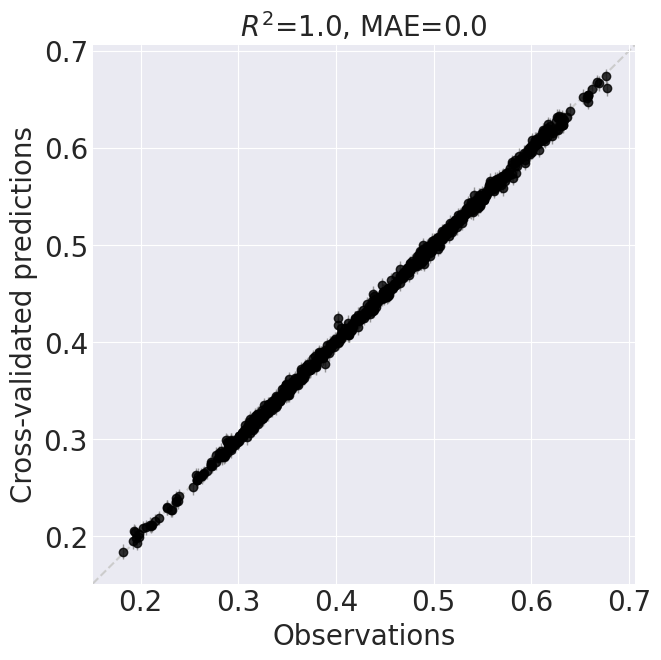

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 129.29 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 164 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 165.80 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.556136e-02,2.109335e+01,6.011834e-02,1.093496e-02,0.025423
Random Forest Regressor,2.897012e-03,6.869113e-01,2.708700e-03,1.572973e-05,0.998598
Support Vector Regressor,5.448051e-02,1.320818e+01,2.544613e-02,3.615632e-03,0.677757
Kernel Ridge Regressor,1.343174e-02,2.964657e+00,1.131698e-02,3.084859e-04,0.972506
K-NN Regressor,2.850835e-02,7.199562e+00,2.472923e-02,1.424261e-03,0.873063
Gaussian Process Regressor,8.889497e-10,2.060244e-07,1.052536e-09,1.898064e-18,1.000000
Gradient Boosting Regressor,5.465785e-03,1.287628e+00,4.994192e-03,5.481675e-05,0.995114
TPOT Regressor,1.751043e-03,4.224684e-01,1.631844e-03,5.729069e-06,0.999489
Ensemble Model,4.585021e-04,1.096969e-01,4.444256e-04,4.077383e-07,0.999964


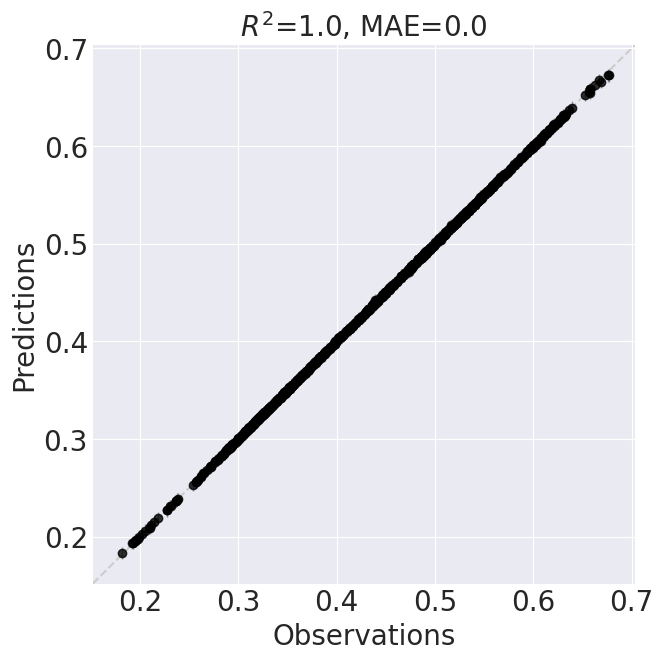

Done building models in 393.55 s
Finding all possible categorical designs…
Done finding categorical designs in 90.79 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.16 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,0.693598
1,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,0.692522
2,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.690706
3,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.689777
4,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,0.688538
5,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,0.687371


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 0.87 s


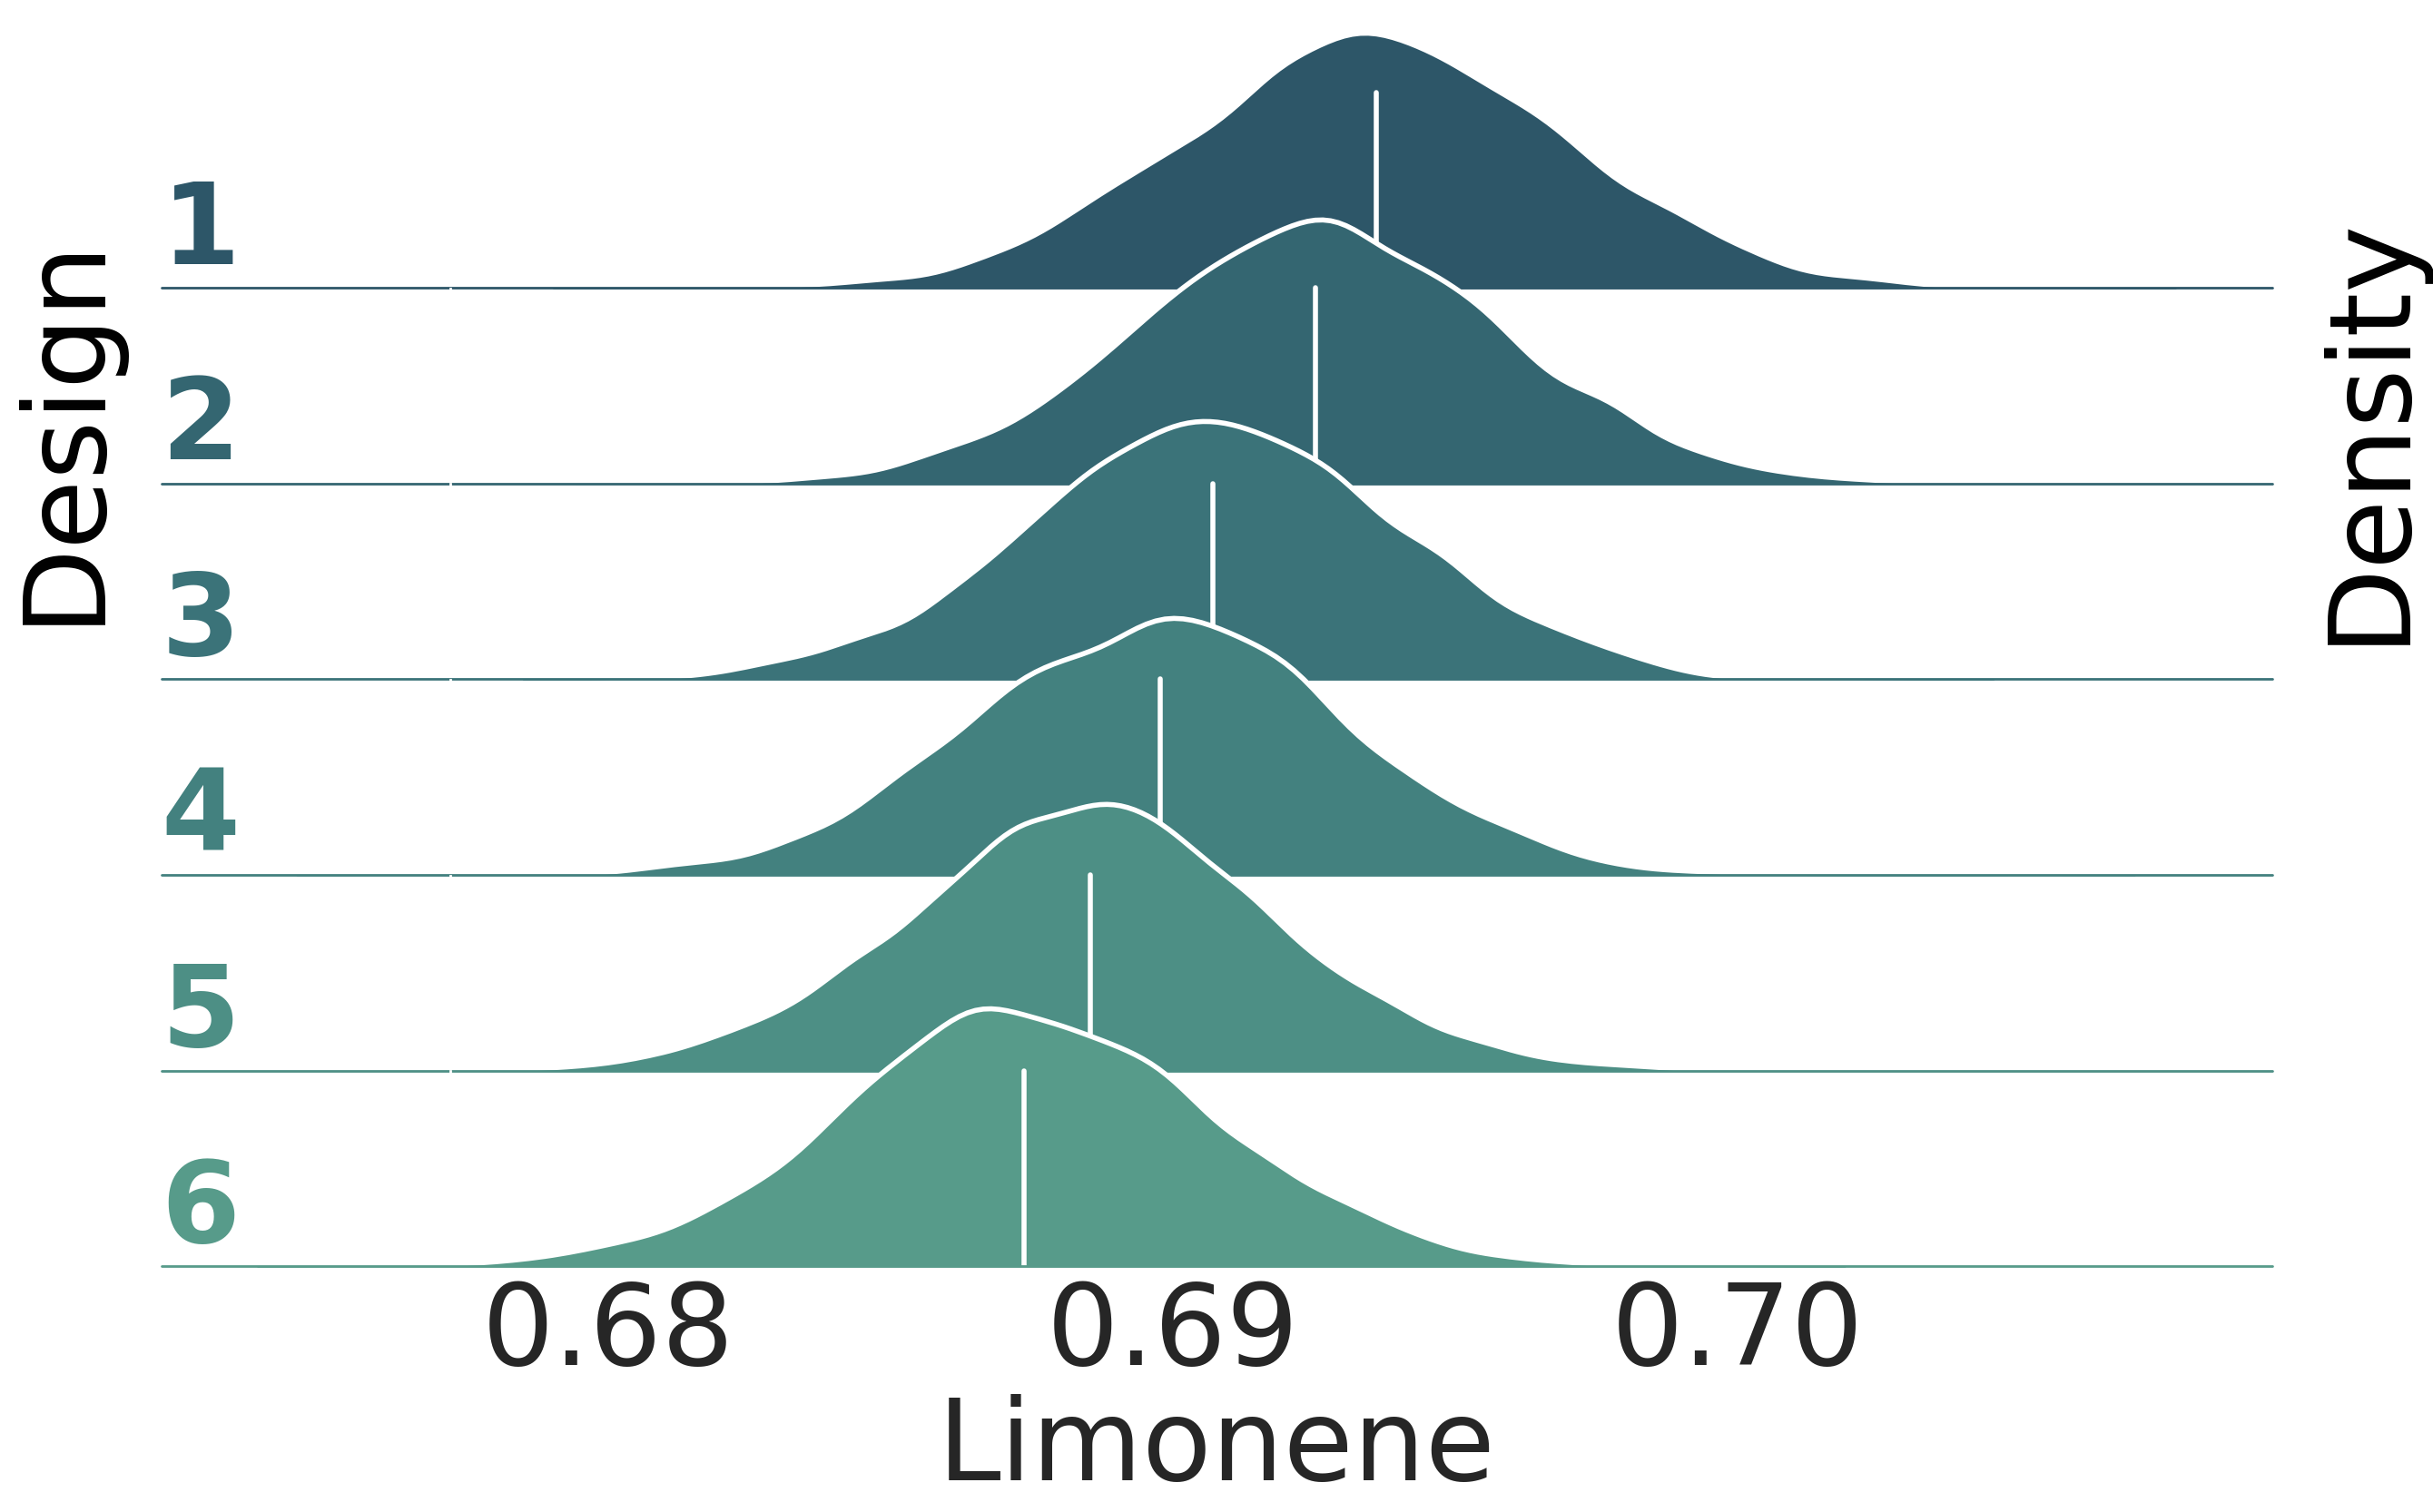

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.83 s
Done computing success probabilities in 0.83 s


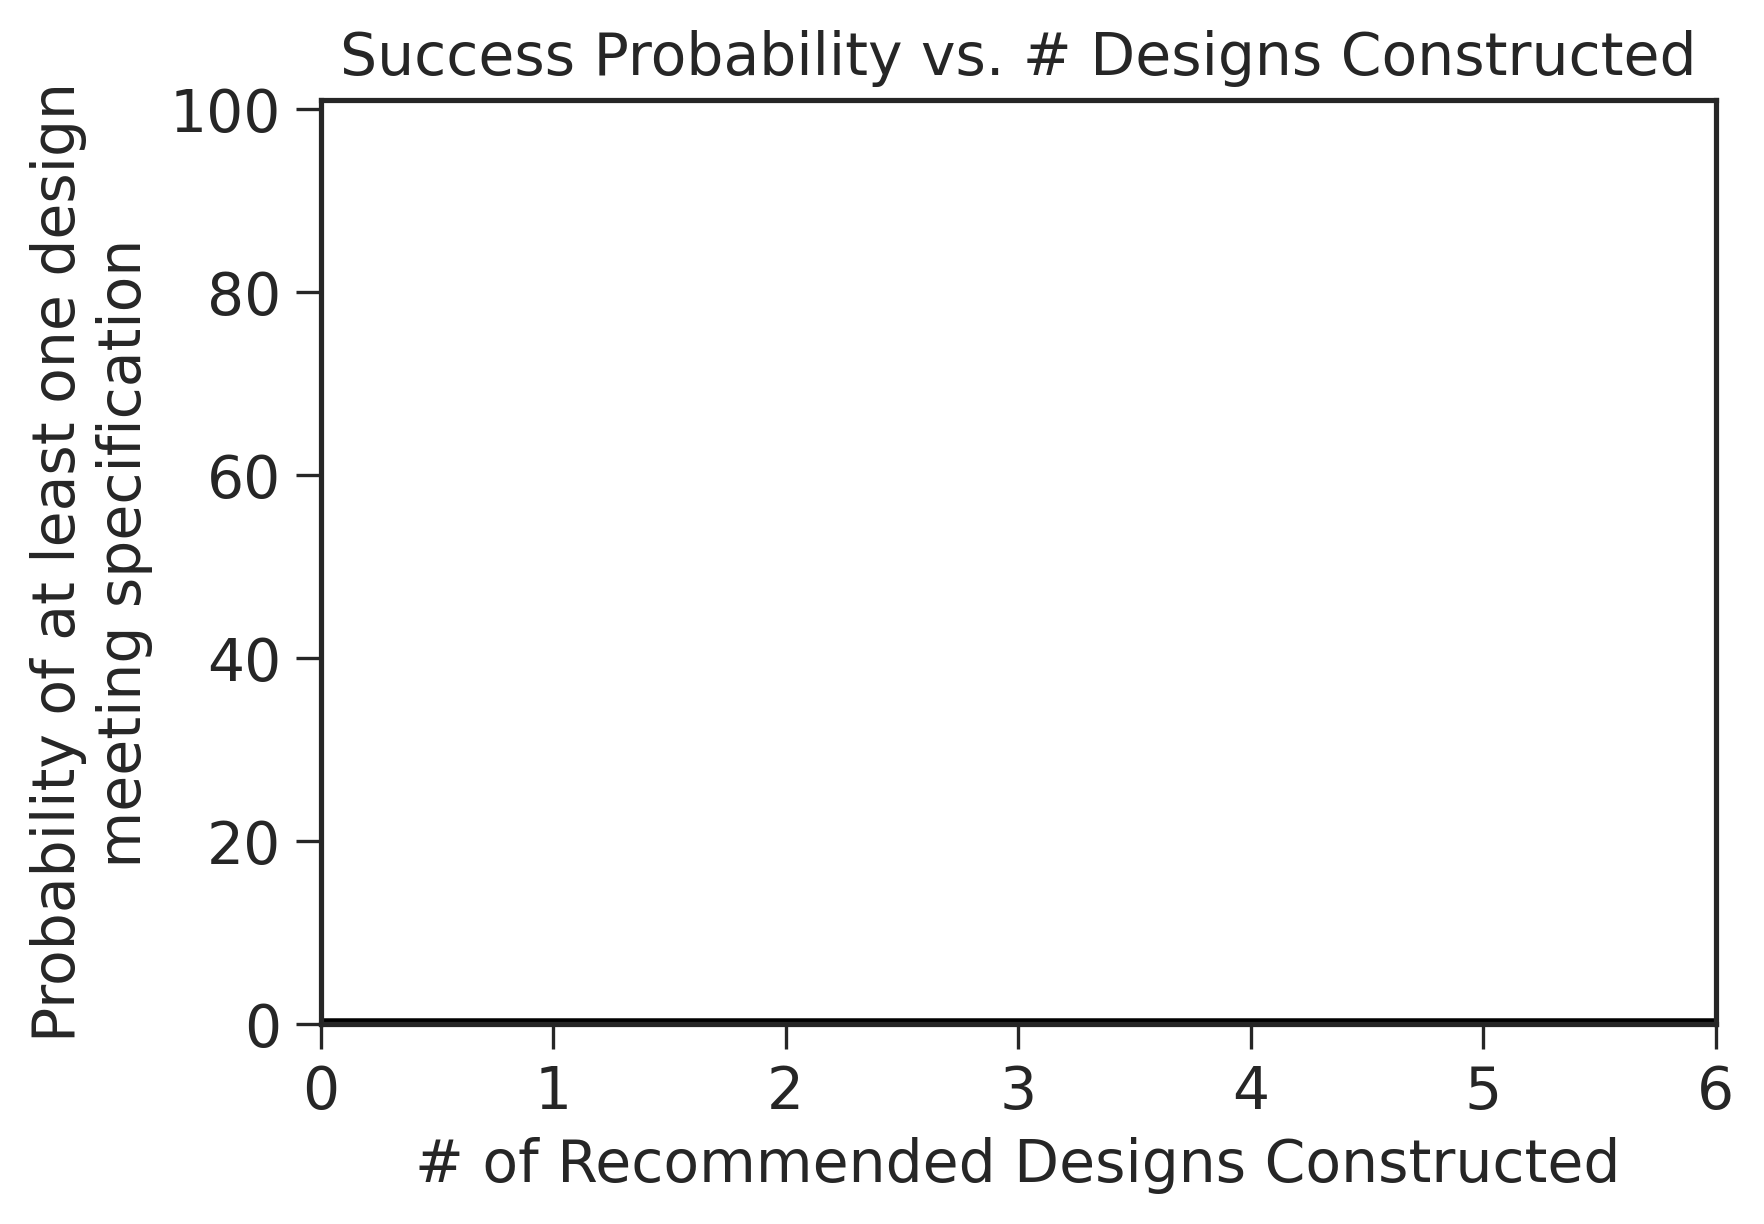

CPU times: user 18min 5s, sys: 24.9 s, total: 18min 30s
Wall time: 33min 21s


In [72]:
%%time
art = RecommendationEngine(df=df, alpha = 0, **art_params)

## alpha = 1

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 1000 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(StandardScaler(input_matrix), learning_rate=0.5, max_depth=3, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)
Done fitting L0 models in 88.67 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 117 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 118.41 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 101.51 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 171 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 172.57 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(XGBRegressor(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9500000000000001, verbosity=0), l1_ratio=1.0, tol=0.1)
Done fitting L0 models in 80.97 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 123 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 124.75 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 117.85 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 153 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 155.10 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 96.09 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 167 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 168.69 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.094746,23.325762,0.067151,0.013486,-0.201948
Random Forest Regressor,0.009047,2.154639,0.008255,0.000150,0.986632
Support Vector Regressor,0.056023,13.673248,0.027224,0.003880,0.654219
Kernel Ridge Regressor,0.019730,4.358650,0.017546,0.000697,0.937869
K-NN Regressor,0.035092,9.019545,0.029721,0.002115,0.811520
Gaussian Process Regressor,0.003128,0.759343,0.002916,0.000018,0.998370
Gradient Boosting Regressor,0.006995,1.652280,0.006458,0.000091,0.991922
TPOT Regressor,0.004670,1.136900,0.004309,0.000040,0.996401
Ensemble Model,0.002587,0.620691,0.002411,0.000013,0.998886


Done with 5-fold cross-validation in 1537.28 s


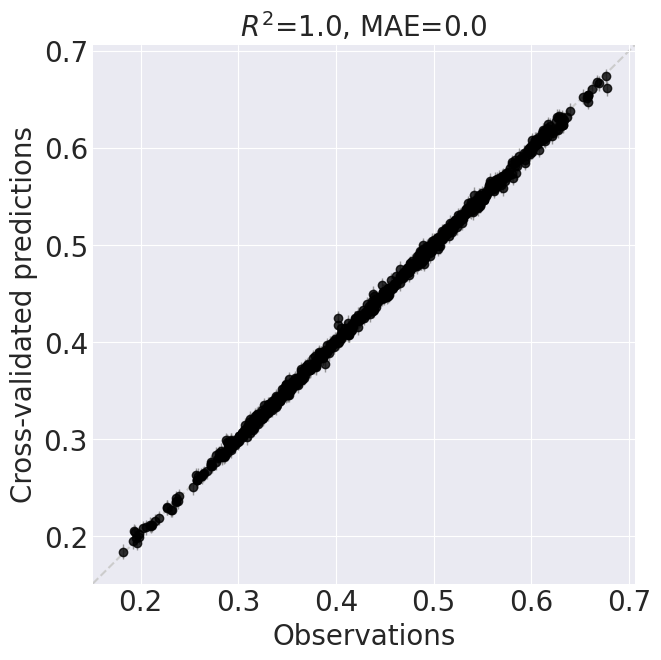

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 130.75 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 162 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 163.47 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.556136e-02,2.109335e+01,6.011834e-02,1.093496e-02,0.025423
Random Forest Regressor,2.897012e-03,6.869113e-01,2.708700e-03,1.572973e-05,0.998598
Support Vector Regressor,5.448051e-02,1.320818e+01,2.544613e-02,3.615632e-03,0.677757
Kernel Ridge Regressor,1.343174e-02,2.964657e+00,1.131698e-02,3.084859e-04,0.972506
K-NN Regressor,2.850835e-02,7.199562e+00,2.472923e-02,1.424261e-03,0.873063
Gaussian Process Regressor,8.889497e-10,2.060244e-07,1.052536e-09,1.898064e-18,1.000000
Gradient Boosting Regressor,5.465785e-03,1.287628e+00,4.994192e-03,5.481675e-05,0.995114
TPOT Regressor,1.751043e-03,4.224684e-01,1.631844e-03,5.729069e-06,0.999489
Ensemble Model,4.585021e-04,1.096969e-01,4.444256e-04,4.077383e-07,0.999964


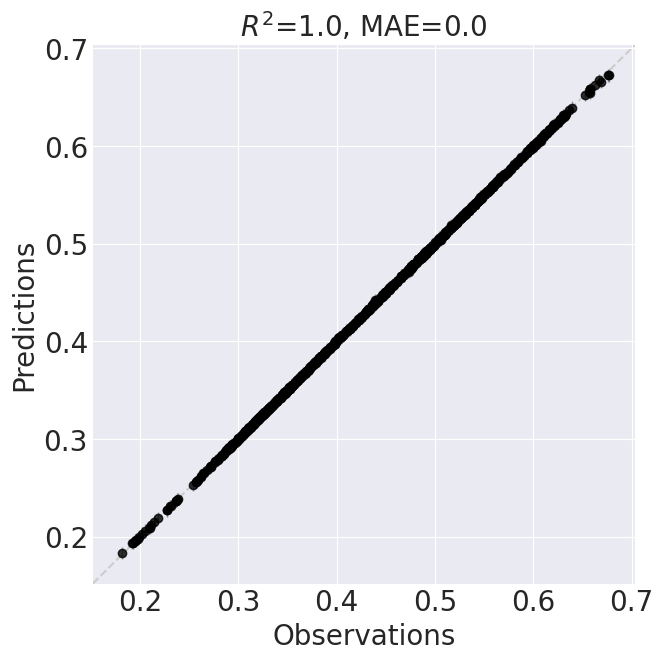

Done building models in 393.90 s
Finding all possible categorical designs…
Done finding categorical designs in 93.53 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.16 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,2.0,2.0,0.677015
1,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,0.680710
2,2.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.666403
3,2.0,2.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,0.664044
4,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.639366
5,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.624598


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 2.72 s


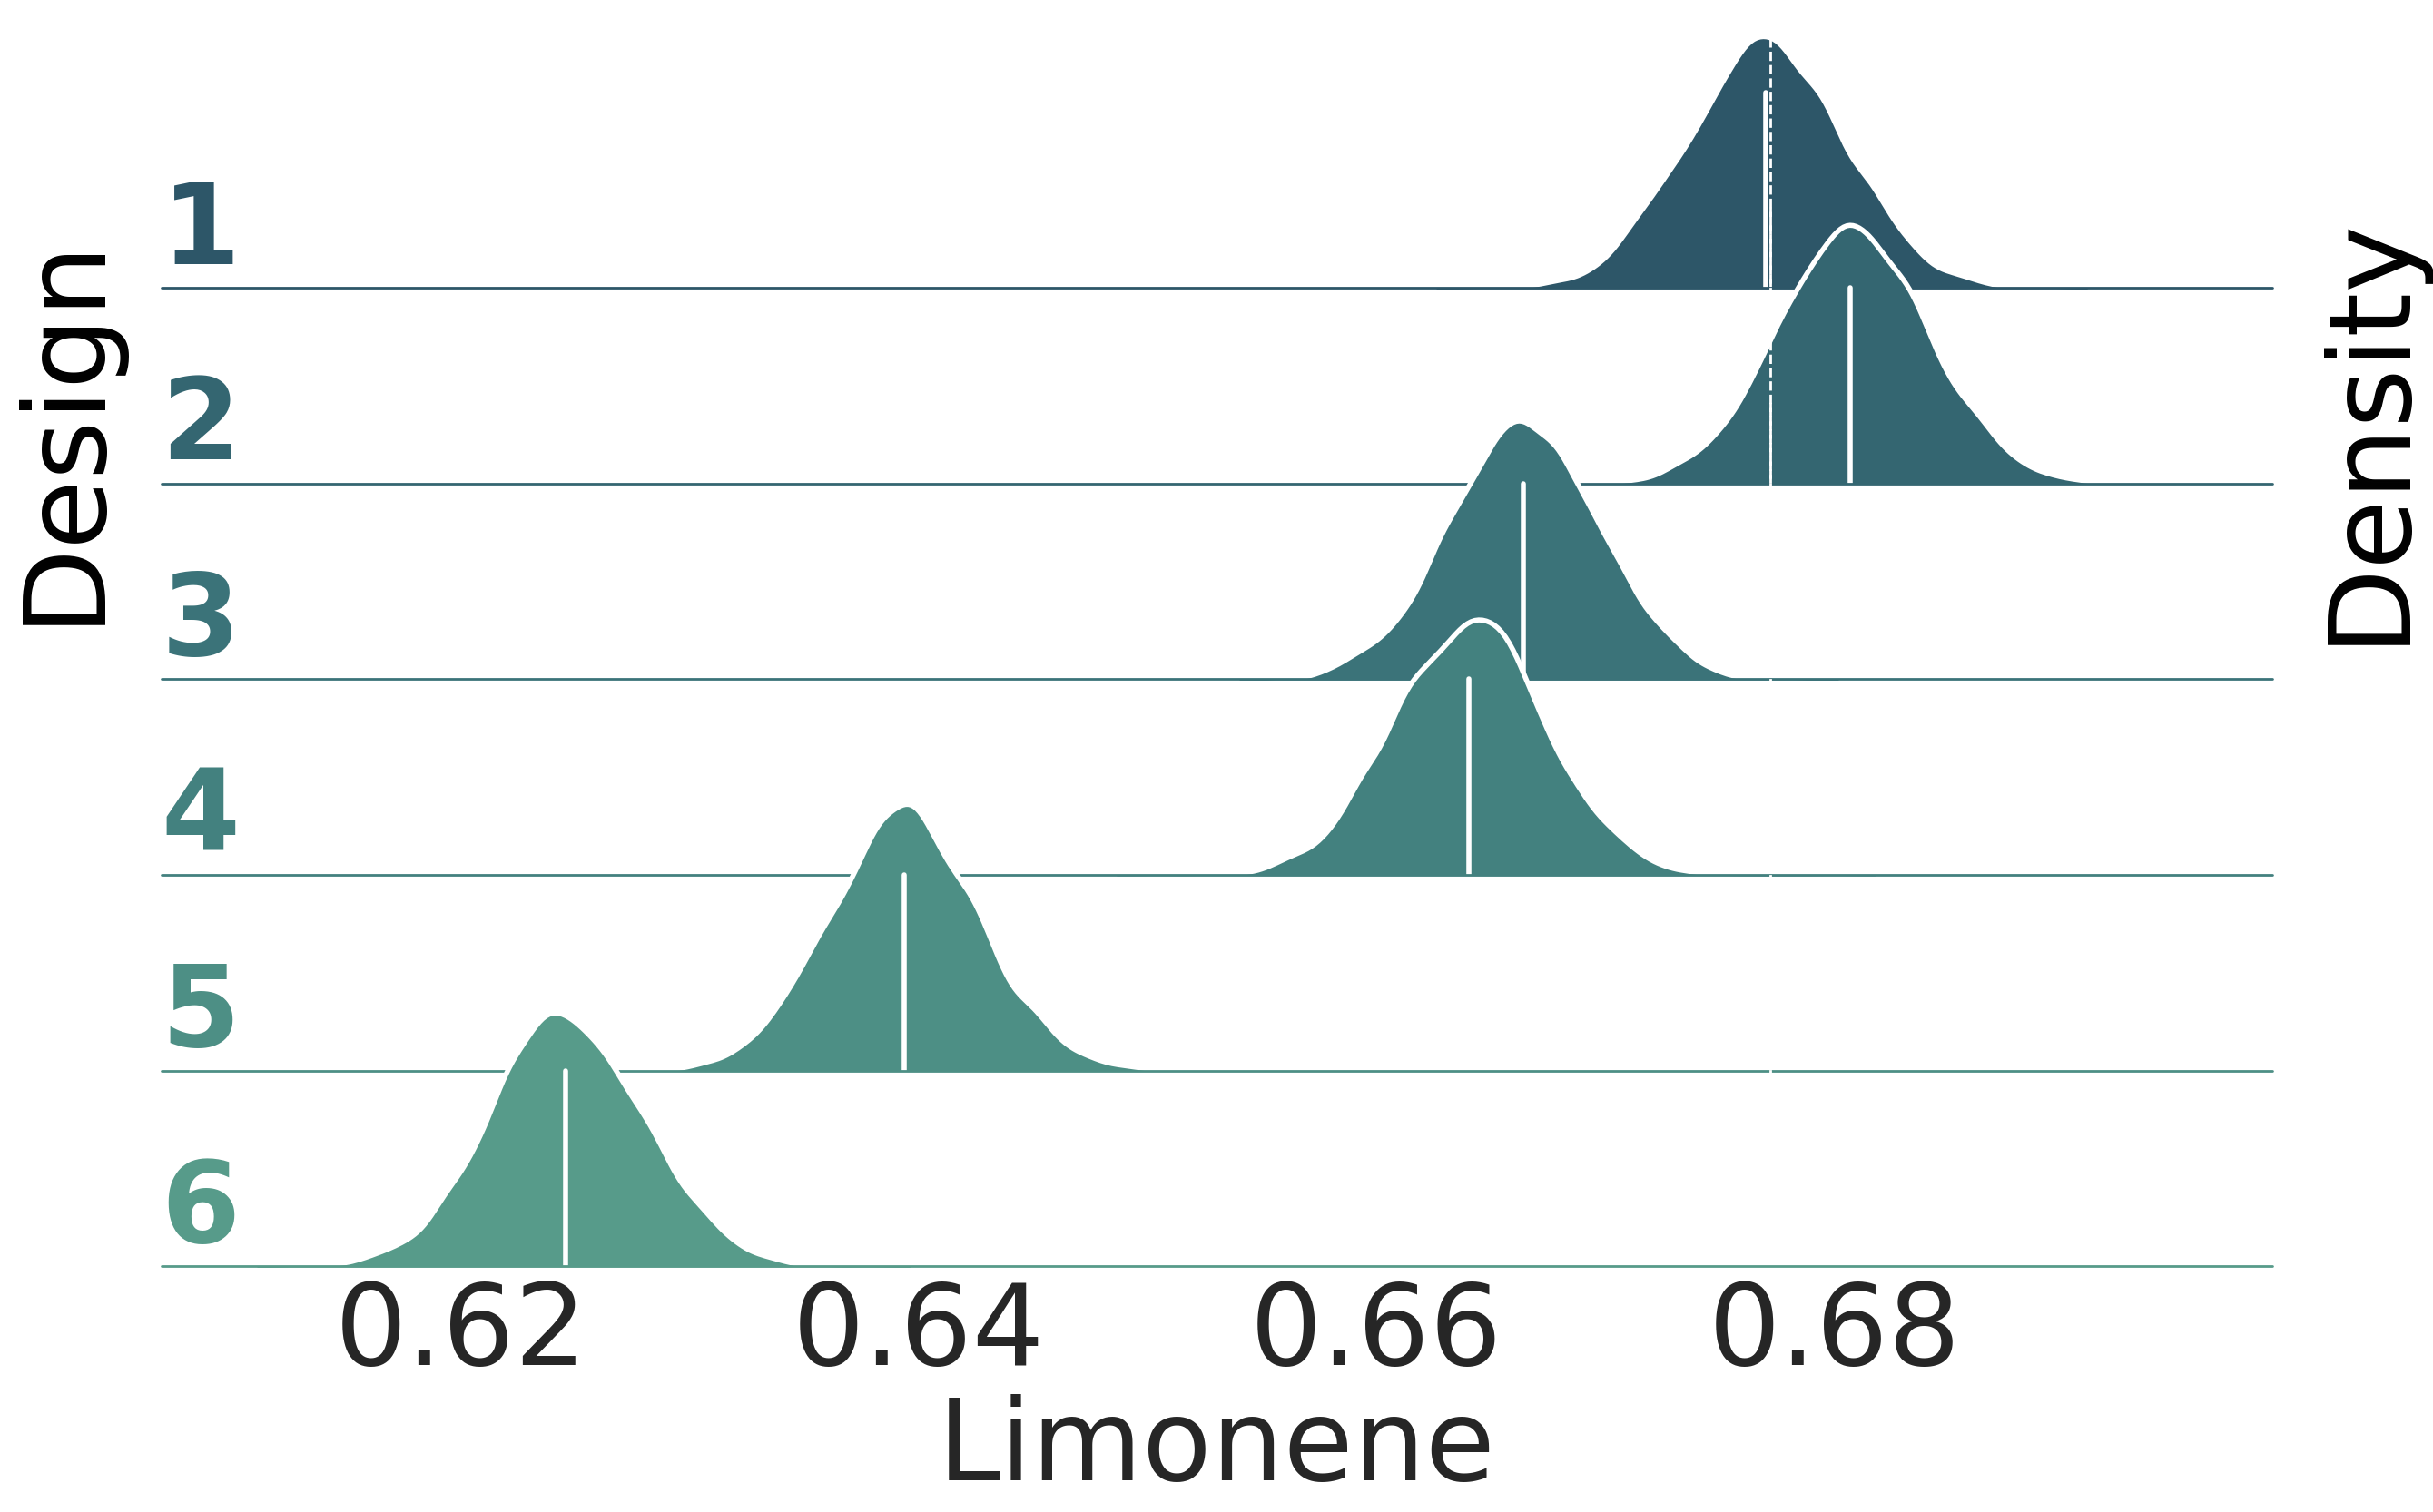

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.97 s
Done computing success probabilities in 0.97 s


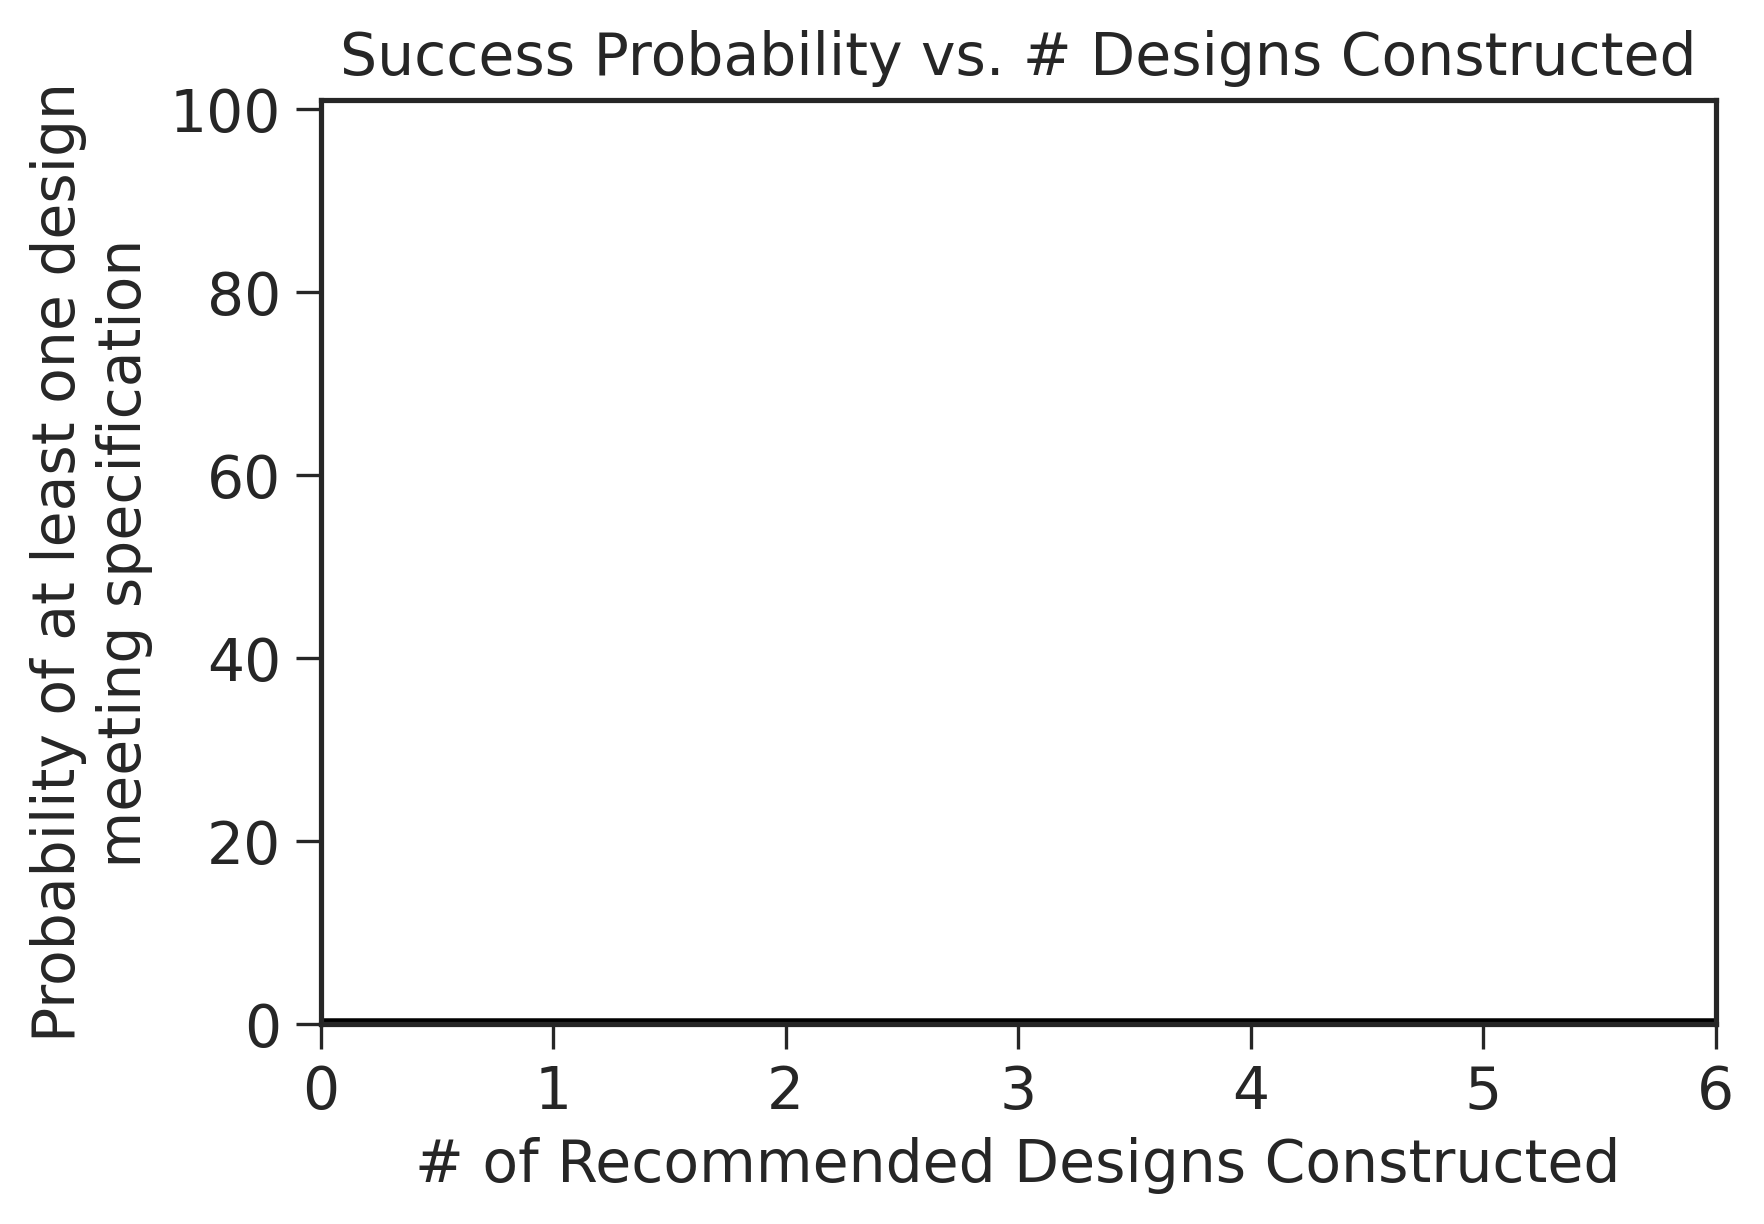

CPU times: user 18min 12s, sys: 1min 6s, total: 19min 19s
Wall time: 33min 53s


In [71]:
%%time
art = RecommendationEngine(df=df, alpha = 1, **art_params)

After the recommendation, select top 3 from alpha = 0 and top 3 from alpha = 1. Conduct the rates fitting again and get another set of rate. Carrying out the mechanistic data augment using the new set of rate. So the following shows the cycle 2.

# Cycle 2

## Data preprocessing

In [5]:
dfl = pd.read_csv("../data/M Model Cycle2/Mechanistic Fitted Data/0rep_0noiseLevel_12strains_initial_design_seed1_1000strains_METABOLITE.csv.csv")

df_l = pd.read_csv("../data/M Model Cycle2/Mechanistic Fitted Data/1000strains_initial_design_seed1.csv")

df_l = df_l.iloc[:,[5,8]]

df_l.index = np.linspace(1,999,999)

W = pd.DataFrame([["WT", "AtoB_1_HMGS_1_HMGR_1_MK_1_PMK_1_PMD_1_GPPS_1_Idi_1_Limonene Synthase_1"]])
W.columns = df_l.columns
df_l = pd.concat([W, df_l], axis = 0)

long_strings = df_l.iloc[:,-1].values.tolist()
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

df_t = pd.DataFrame(dict_list)

df = pd.concat([df_l.iloc[:,0],df_t], axis = 1)

dfl = dfl[dfl['Time/hours'] == 24.0]

dfl = dfl.iloc[:,-1]

dfl.index = np.linspace(0, 999, 1000)    # manually adjust

df = pd.concat([df, dfl], axis = 1, ignore_index=True)

df.columns = ['Strain', 'AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi', 'Limonene Synthase', 'Limonene']

df['Limonene'].to_csv("../data/M Model Cycle2/Original_Ob.csv", index = False)

# transform the format

df = pd.melt(df, id_vars=['Strain'], 
                    value_vars=['AtoB', 'HMGS', 'HMGR', 'MK','PMK','PMD','GPPS','Idi','Limonene Synthase','Limonene'],
                    var_name='Measurement Type', value_name='Value')

df.to_csv("../data/M Model Cycle2/Level_data.csv", index = False)

## Defining parameters

In [14]:
"""
Defining all the required parameters. 
Attention to input_var_type paramter, our case is about categorical variables.

Trying different alpha from 0 to 1 to get different recommendations.

Finally, take 3 recommendations from alpha = 0 and another 3 from alpha = 1.

"""



user_params = {
    'data_file': '../data/M Model Cycle2/Level_data.csv',            # Training data file
    'response_vars': ["Limonene"],     # Response variable
    'input_vars': ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD',
                   'GPPS', 'Idi', 'Limonene Synthase'],  # A list of the relevant input variables (features) to use for model building    ,
    'objective': 'maximize',                                      # Type of the objective
    'threshold': 0.2,                                             # Relative threshold for defining success (e.g. setting to 0.2 means
    # improving the production from the best in the data set by 20% is considered a success)
    'num_recommendations': 6,  # Number of recommendations to be provided
    'n_instances_cycle1': 12,
    'max_mcmc_cores': 2,
    'cross_val': True,
    'output_dir': '../results/M Model Cycle2/Level_result',                          # Directory to store output files
    'verbose': 1                                                  # Amount of information to be displayed
}

In [15]:
cycle = 2

In [16]:
df = utils.load_study(data_file=user_params['data_file'])

In [17]:
df.columns = ['Line Name', 'Measurement Type', 'Value']

In [18]:
df

,Line Name,Measurement Type,Value
0,WT,AtoB,1.000000
1,Strain 1,AtoB,1.000000
2,Strain 2,AtoB,2.000000
3,Strain 3,AtoB,0.000000
4,Strain 4,AtoB,0.000000
...,...,...,...
9995,Strain 995,Limonene,0.523758
9996,Strain 996,Limonene,0.360138
9997,Strain 997,Limonene,0.485817
9998,Strain 998,Limonene,0.310579


## alpha = 0

In [19]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'] + "_alpha = 0",
    'last_dashes_denote_replicates': False,
    'cross_val_partitions': 5,
    'input_var_type': 'categorical',
}

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 1000 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 94.91 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 138 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 139.39 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(CombineDFs(input_matrix, input_matrix), learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 86.62 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 167 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 168.65 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)
Done fitting L0 models in 60.44 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 122 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 124.14 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.5, verbosity=0)
Done fitting L0 models in 101.29 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 143 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 144.90 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(StandardScaler(input_matrix), learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 104.38 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 133 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 135.50 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.094840,23.214506,0.067165,0.013506,-0.209514
Random Forest Regressor,0.008875,2.094551,0.008245,0.000147,0.986858
Support Vector Regressor,0.055877,13.545707,0.027306,0.003868,0.653617
Kernel Ridge Regressor,0.019763,4.346913,0.017530,0.000698,0.937503
K-NN Regressor,0.035057,8.968081,0.029717,0.002112,0.810850
Gaussian Process Regressor,0.003019,0.730398,0.002822,0.000017,0.998470
Gradient Boosting Regressor,0.006860,1.624068,0.006269,0.000086,0.992266
TPOT Regressor,0.004698,1.122309,0.004314,0.000041,0.996357
Ensemble Model,0.002608,0.622563,0.002374,0.000012,0.998886


Done with 5-fold cross-validation in 1416.70 s


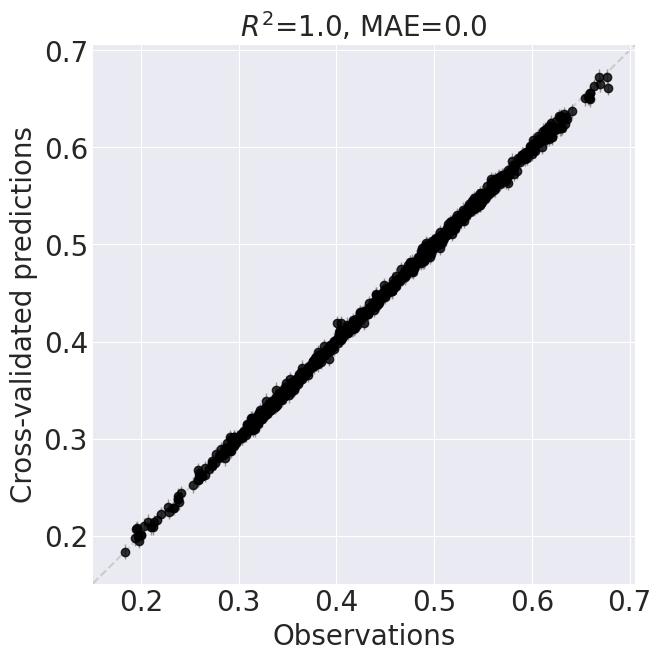

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 117.40 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 162 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 163.97 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.564925e-02,2.099365e+01,6.016828e-02,1.095602e-02,0.018838
Random Forest Regressor,2.847200e-03,6.679898e-01,2.709705e-03,1.544905e-05,0.998616
Support Vector Regressor,5.433285e-02,1.307452e+01,2.561489e-02,3.608181e-03,0.676871
Kernel Ridge Regressor,1.343679e-02,2.952565e+00,1.130127e-02,3.082658e-04,0.972393
K-NN Regressor,2.845111e-02,7.151796e+00,2.472297e-02,1.420691e-03,0.872771
Gaussian Process Regressor,9.221404e-10,2.128264e-07,1.085630e-09,2.028935e-18,1.000000
Gradient Boosting Regressor,5.628174e-03,1.337136e+00,5.149935e-03,5.819818e-05,0.994788
TPOT Regressor,1.569762e-03,3.698590e-01,1.332536e-03,4.239805e-06,0.999620
Ensemble Model,4.699257e-04,1.088446e-01,4.150939e-04,3.931331e-07,0.999965


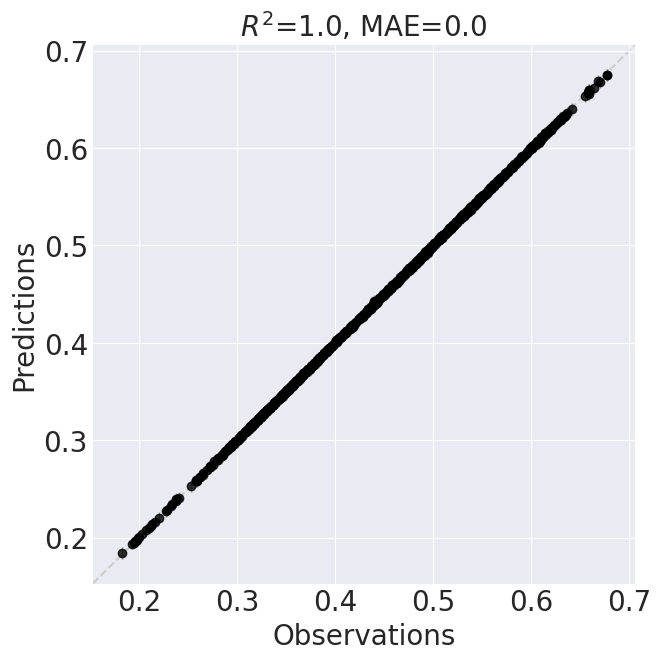

Done building models in 360.11 s
Finding all possible categorical designs…
Done finding categorical designs in 91.13 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.16 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,0.692462
1,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,0.691661
2,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.689881
3,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.688686
4,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,0.688367
5,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,0.687697


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.90 s


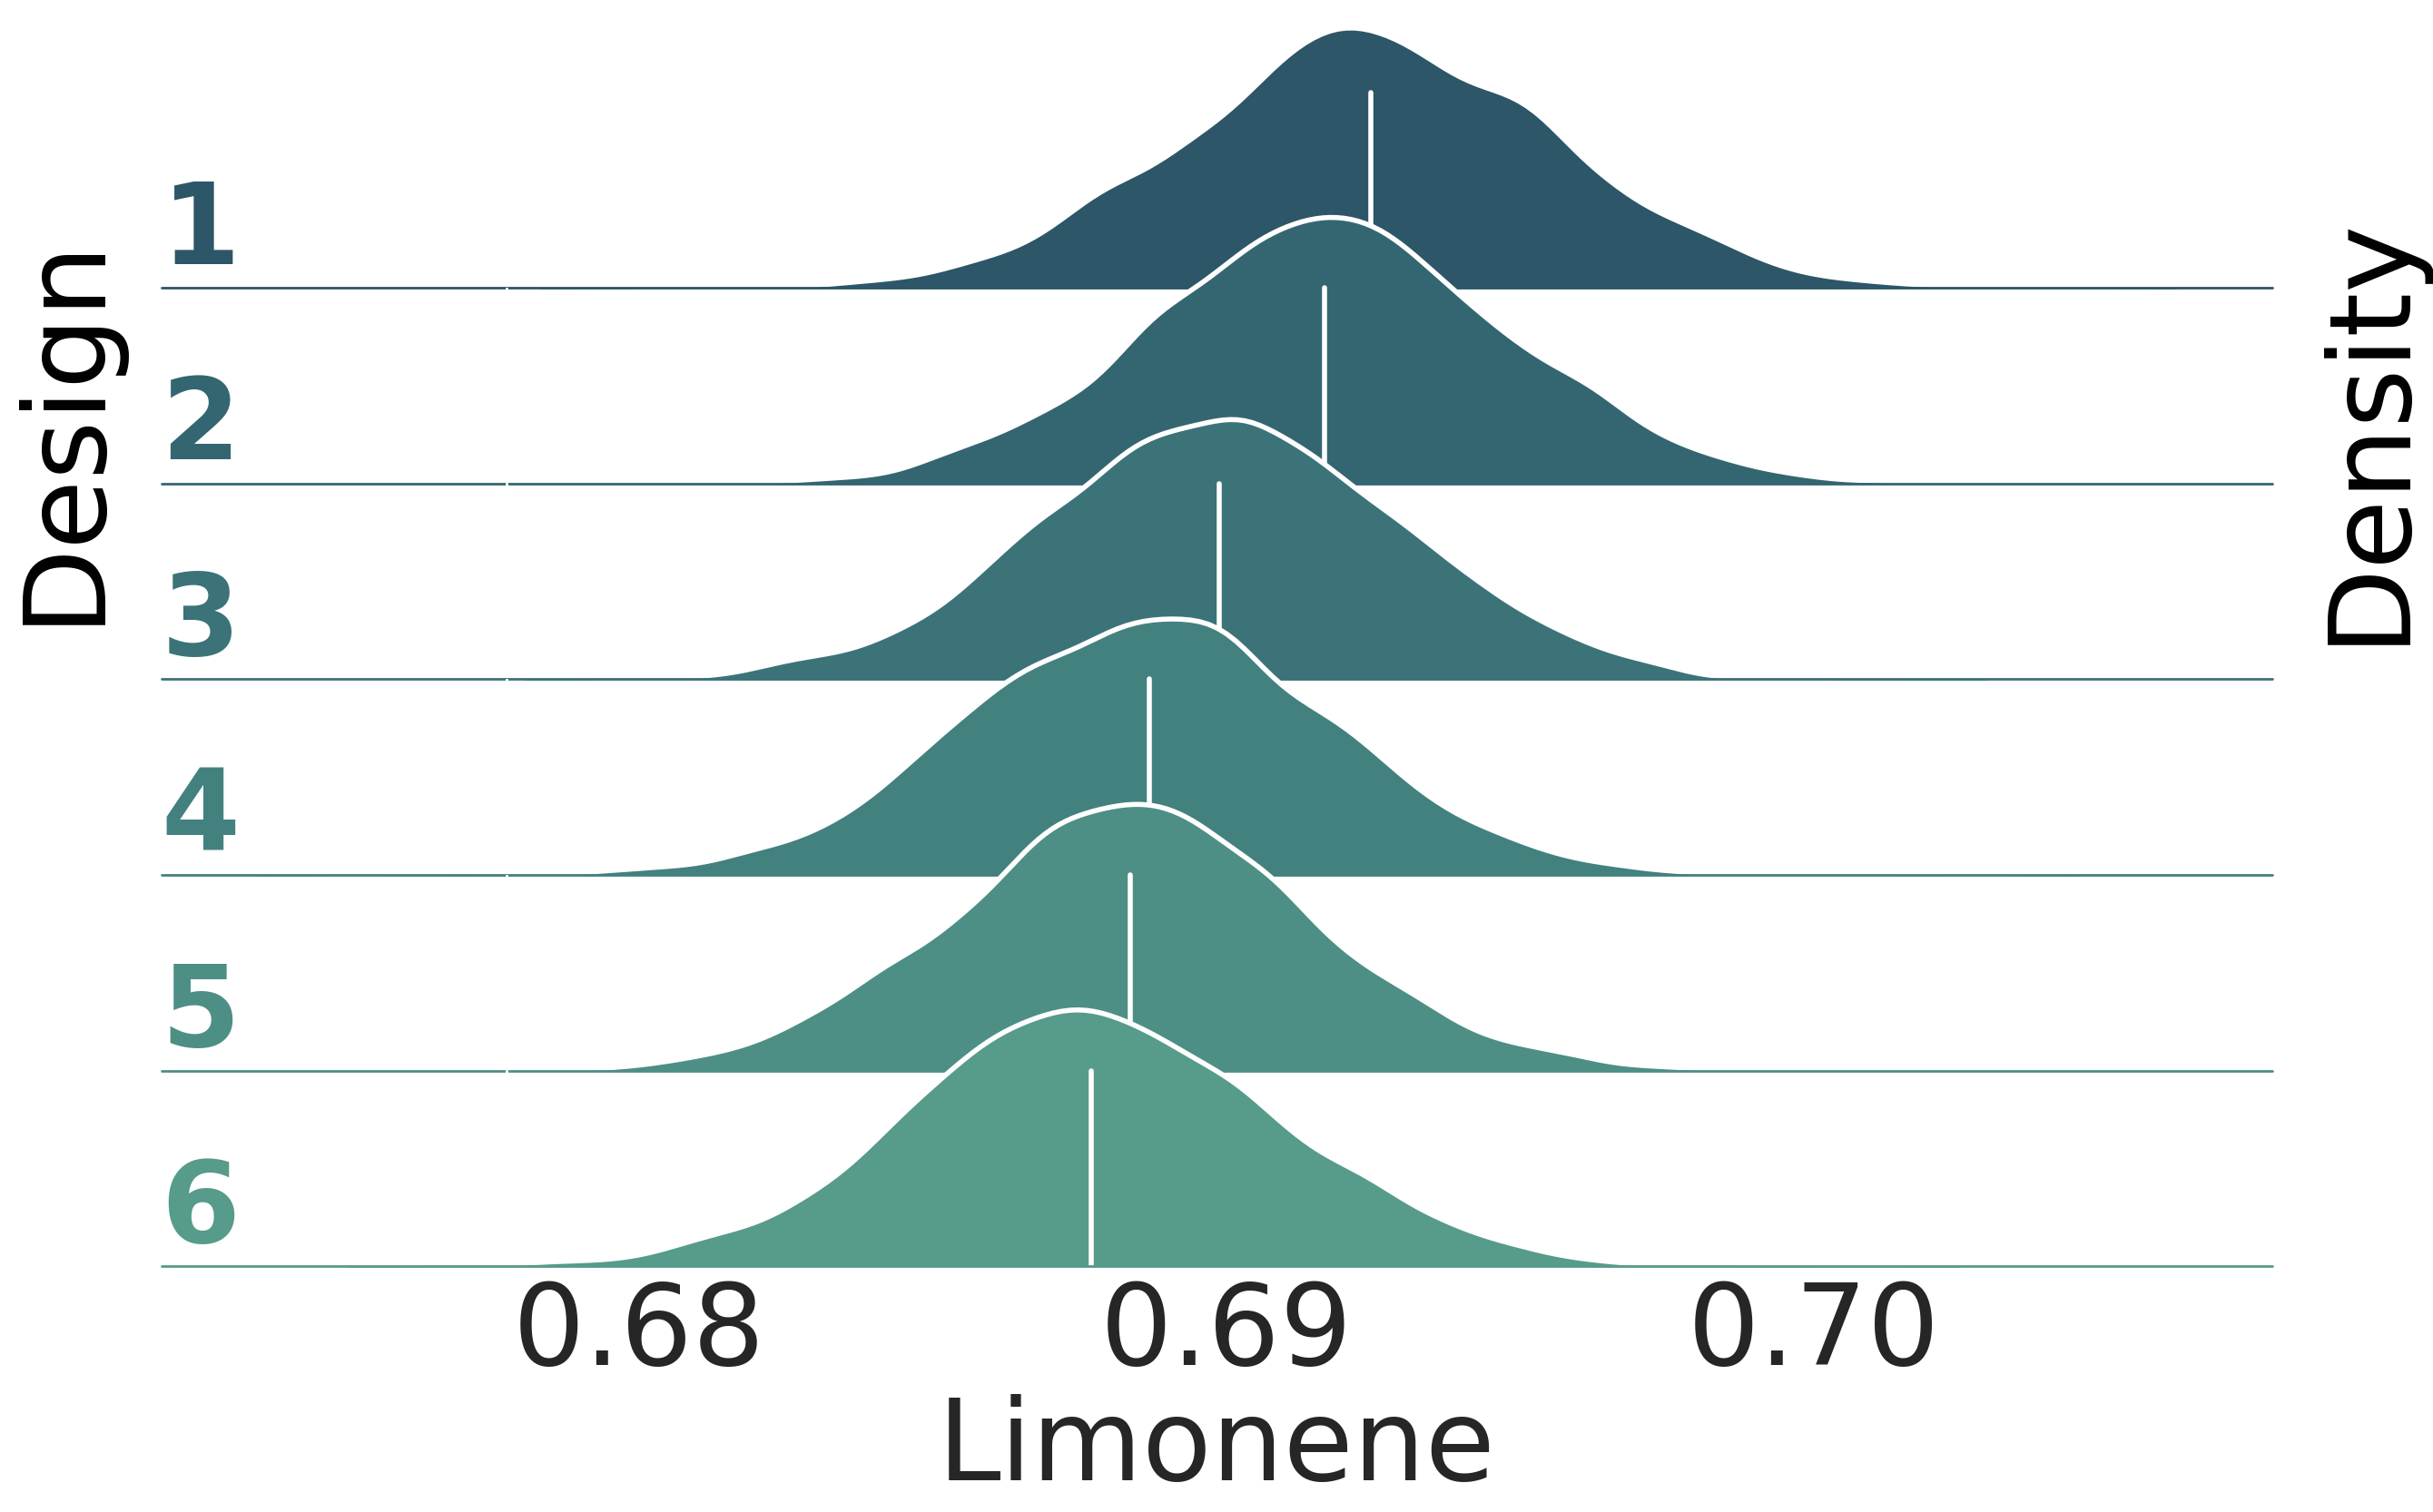

Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.40 s
Done computing success probabilities in 1.41 s


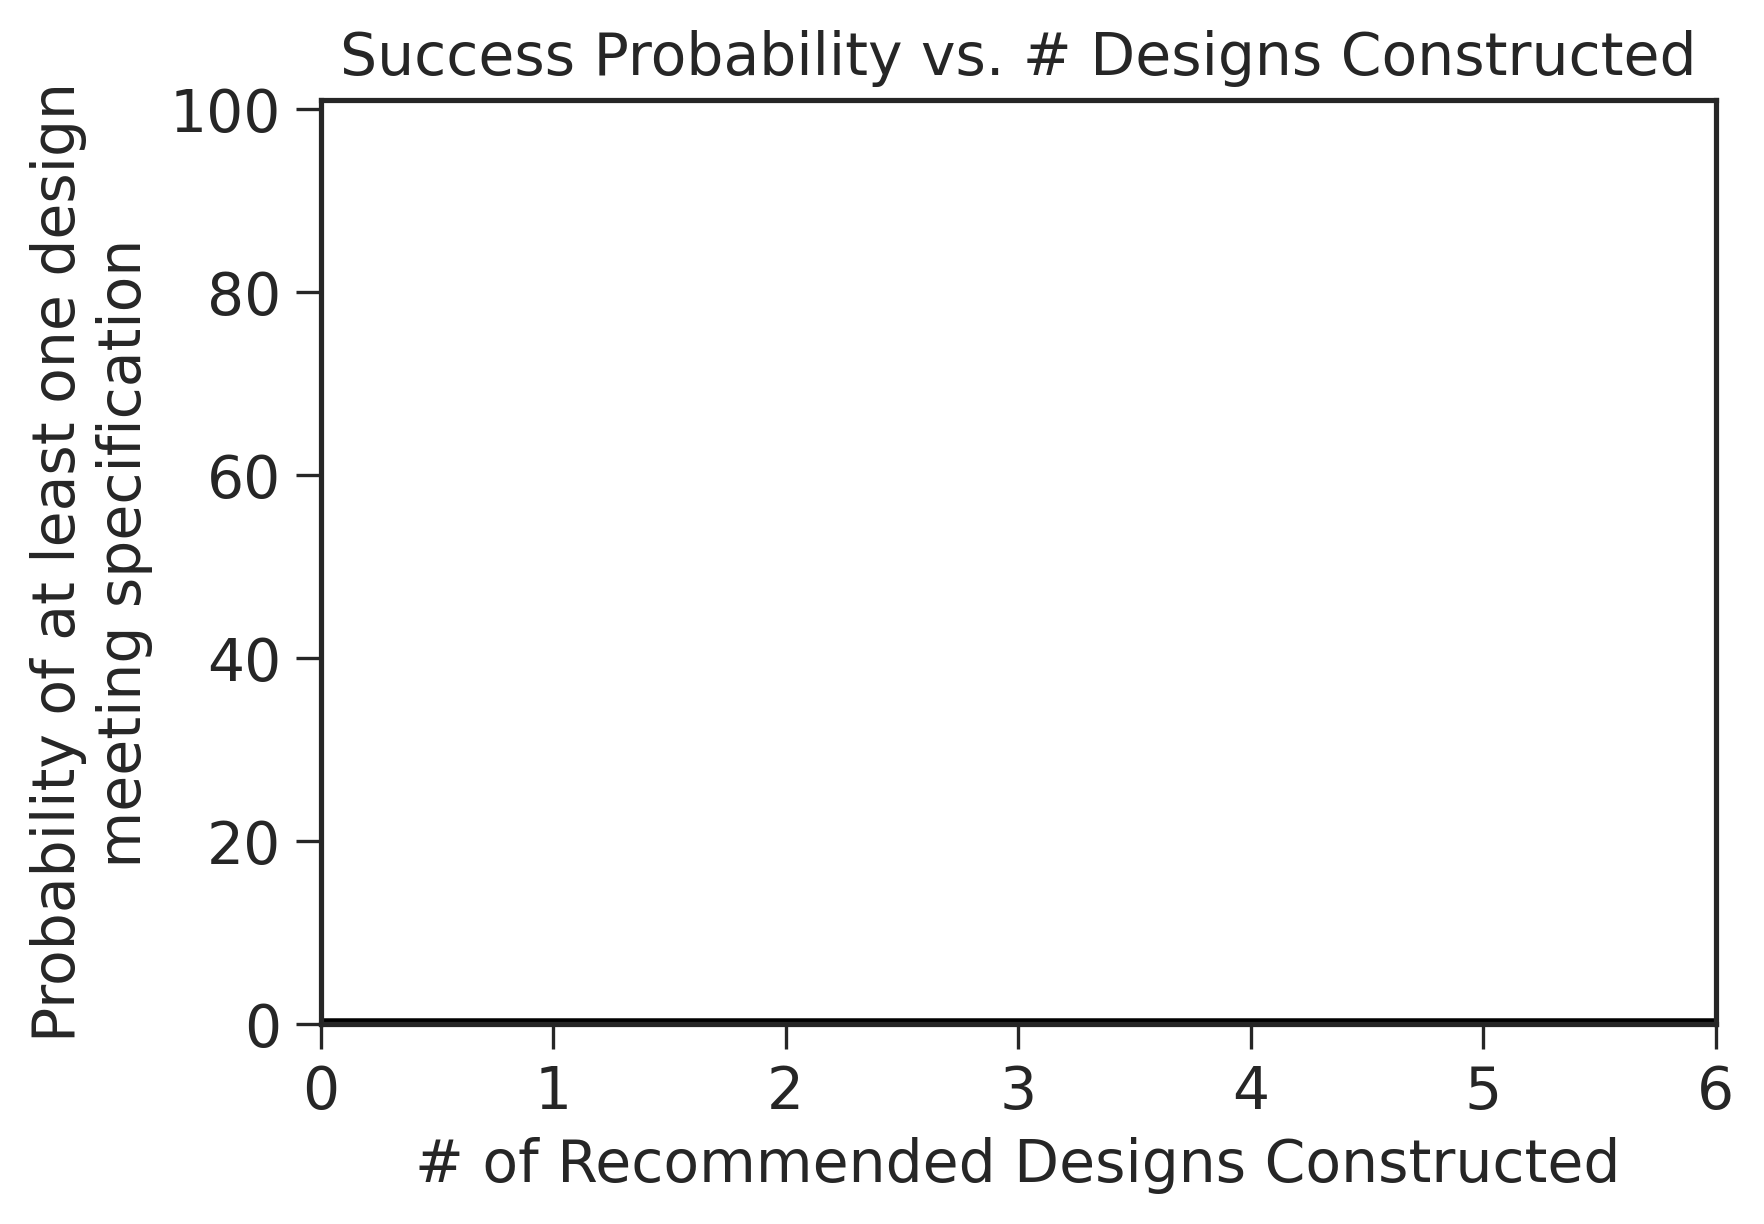

CPU times: user 16min 47s, sys: 23.8 s, total: 17min 11s
Wall time: 31min 18s


In [20]:
%%time
art = RecommendationEngine(df=df, alpha = 0, **art_params)

## alpha = 1

In [21]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'] + "_alpha = 1",
    'last_dashes_denote_replicates': False,
    'cross_val_partitions': 5,
    'input_var_type': 'categorical',
}

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 1000 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 98.52 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10956 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 10958.33 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(CombineDFs(input_matrix, input_matrix), learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 8253.37 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 1142 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 1144.07 s
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)
Done fitting L0 models in 61.63 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 111 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 112.83 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.5, verbosity=0)
Done fitting L0 models in 98.10 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 136 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 137.98 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(StandardScaler(input_matrix), learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 100.36 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 132 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 133.97 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.094840,23.214506,0.067165,0.013506,-0.209514
Random Forest Regressor,0.008875,2.094551,0.008245,0.000147,0.986858
Support Vector Regressor,0.055877,13.545707,0.027306,0.003868,0.653617
Kernel Ridge Regressor,0.019763,4.346913,0.017530,0.000698,0.937503
K-NN Regressor,0.035057,8.968081,0.029717,0.002112,0.810850
Gaussian Process Regressor,0.003019,0.730398,0.002822,0.000017,0.998470
Gradient Boosting Regressor,0.006860,1.624068,0.006269,0.000086,0.992266
TPOT Regressor,0.004698,1.122309,0.004314,0.000041,0.996357
Ensemble Model,0.002608,0.622563,0.002374,0.000012,0.998886


Done with 5-fold cross-validation in 27697.59 s


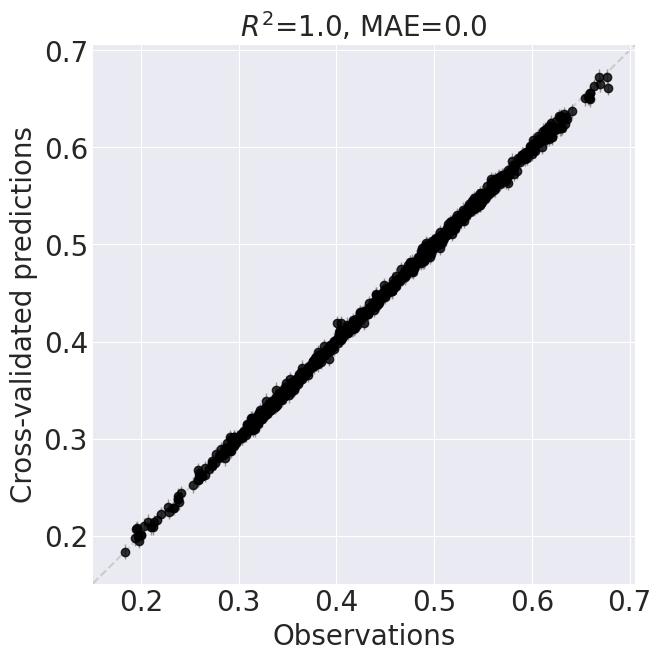

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 120.87 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 156 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 157.76 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.564925e-02,2.099365e+01,6.016828e-02,1.095602e-02,0.018838
Random Forest Regressor,2.847200e-03,6.679898e-01,2.709705e-03,1.544905e-05,0.998616
Support Vector Regressor,5.433285e-02,1.307452e+01,2.561489e-02,3.608181e-03,0.676871
Kernel Ridge Regressor,1.343679e-02,2.952565e+00,1.130127e-02,3.082658e-04,0.972393
K-NN Regressor,2.845111e-02,7.151796e+00,2.472297e-02,1.420691e-03,0.872771
Gaussian Process Regressor,9.221404e-10,2.128264e-07,1.085630e-09,2.028935e-18,1.000000
Gradient Boosting Regressor,5.628174e-03,1.337136e+00,5.149935e-03,5.819818e-05,0.994788
TPOT Regressor,1.569762e-03,3.698590e-01,1.332536e-03,4.239805e-06,0.999620
Ensemble Model,4.699257e-04,1.088446e-01,4.150939e-04,3.931331e-07,0.999965


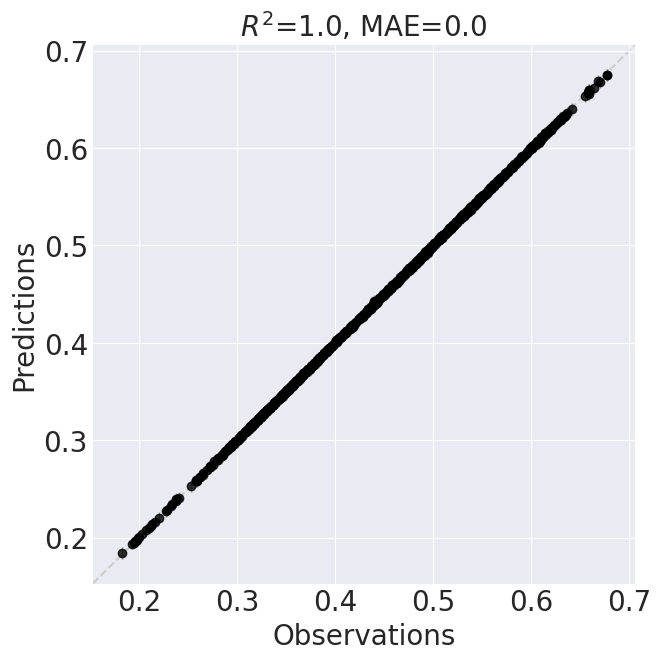

Done building models in 354.24 s
Finding all possible categorical designs…
Done finding categorical designs in 90.20 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.15 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,0.679627
1,2.0,2.0,2.0,1.0,2.0,0.0,2.0,2.0,2.0,0.675953
2,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,0.655148
3,2.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.664680
4,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.655816
5,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.657701


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.91 s


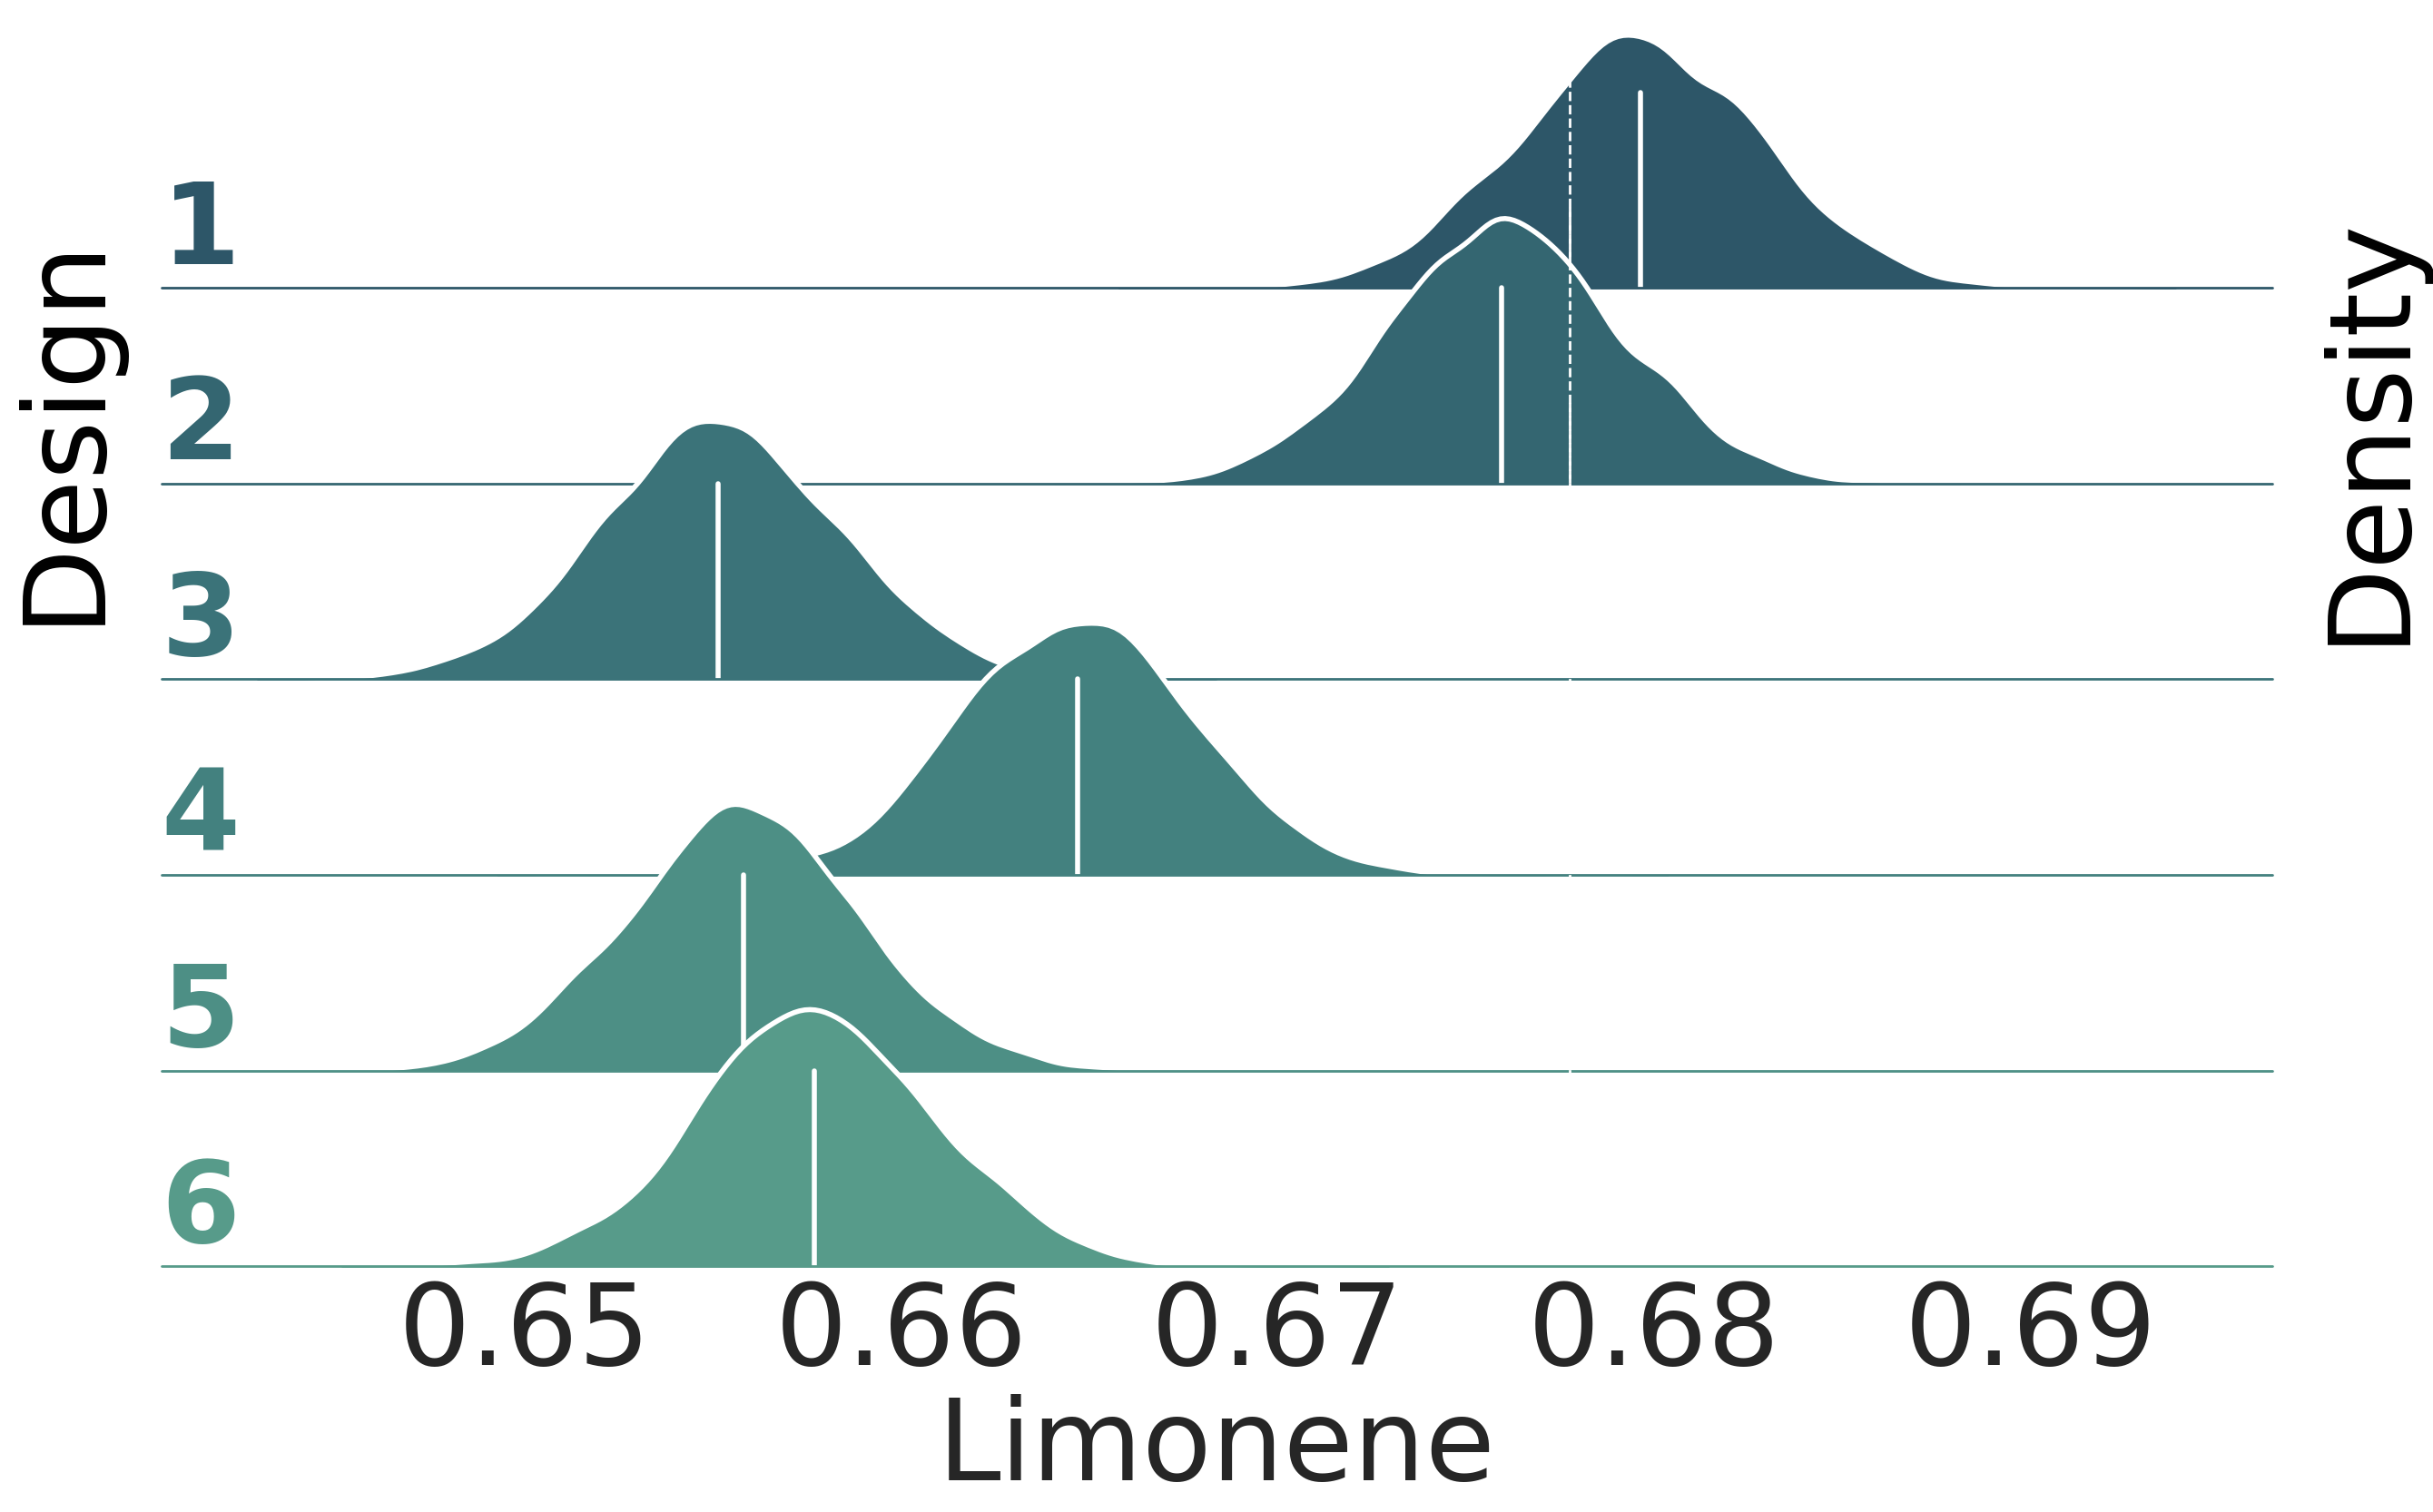

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.88 s
Done computing success probabilities in 0.88 s


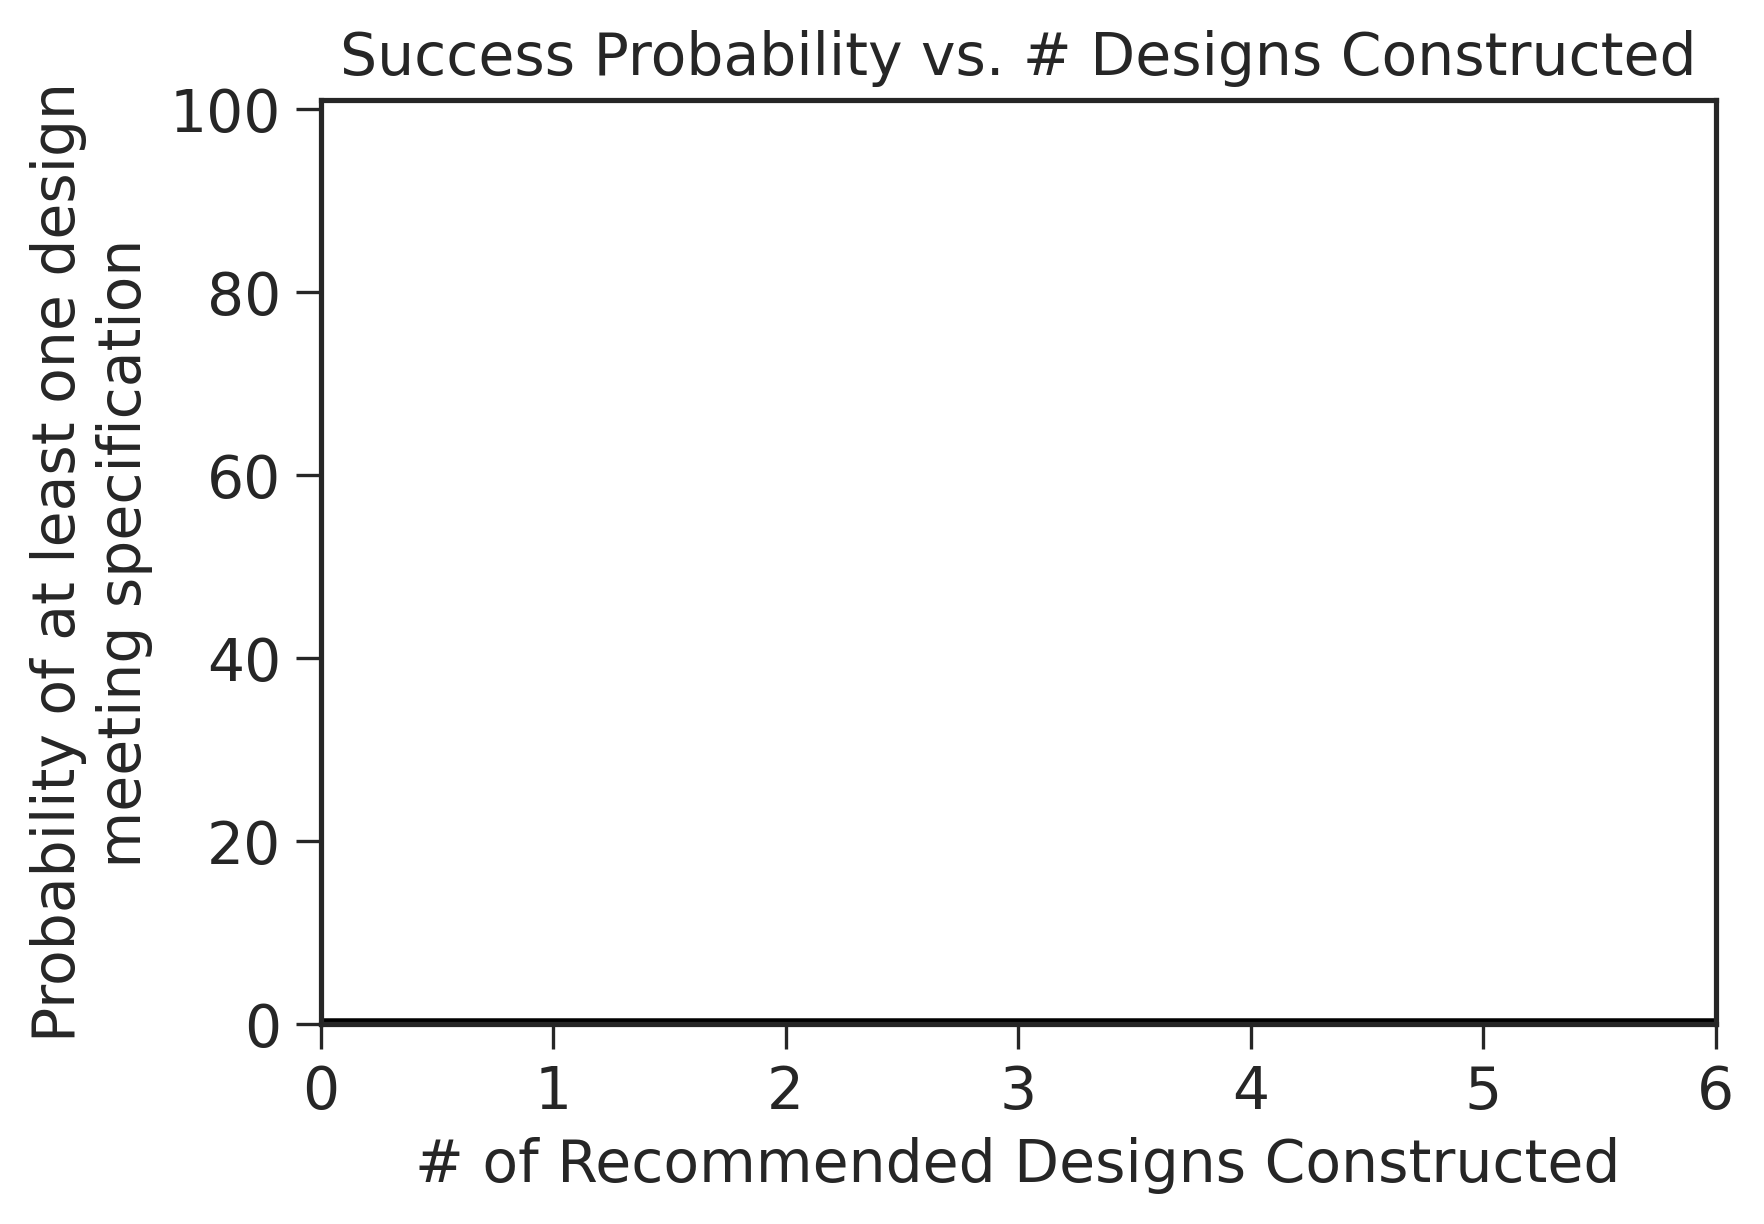

CPU times: user 17min 10s, sys: 25.4 s, total: 17min 36s
Wall time: 7h 49min 12s


In [22]:
%%time
art = RecommendationEngine(df=df, alpha = 1, **art_params)

The recommendations provided by the Cycle 2 are mostly the same as Cycle 1's

# Cycle 3

## Data Preprocessing
Run all this part in another .ipynb file

In [ ]:
dfl = pd.read_csv("../data/M Model Cycle3/Mechanistic Fitted Data/0rep_0noiseLevel_12strains_initial_design_seed1_1000strains_METABOLITE.csv.csv")

df_l = pd.read_csv("../data/M Model Cycle3/Mechanistic Fitted Data/1000strains_initial_design_seed1.csv")

df_l = df_l.iloc[:,[5,8]]

df_l.index = np.linspace(1,999,999)

W = pd.DataFrame([["WT", "AtoB_1_HMGS_1_HMGR_1_MK_1_PMK_1_PMD_1_GPPS_1_Idi_1_Limonene Synthase_1"]])
W.columns = df_l.columns
df_l = pd.concat([W, df_l], axis = 0)

long_strings = df_l.iloc[:,-1].values.tolist()
dict_list = []

for string in long_strings:
    # split the character
    parts = string.split('_')
    # transfer the splitted value to a dictionary（even index as key，odd index as value）
    it = iter(parts)
    dictionary = dict(zip(it, it))
    # append to the list
    dict_list.append(dictionary)

df_t = pd.DataFrame(dict_list)

df = pd.concat([df_l.iloc[:,0],df_t], axis = 1)

dfl = dfl[dfl['Time/hours'] == 24.0]

dfl = dfl.iloc[:,-1]

dfl.index = np.linspace(0, 999, 1000)    # manually adjust

df = pd.concat([df, dfl], axis = 1, ignore_index=True)

df.columns = ['Strain', 'AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi', 'Limonene Synthase', 'Limonene']

df['Limonene'].to_csv("../data/M Model Cycle3/Original_Ob.csv", index = False)

# transform the format

df = pd.melt(df, id_vars=['Strain'], 
                    value_vars=['AtoB', 'HMGS', 'HMGR', 'MK','PMK','PMD','GPPS','Idi','Limonene Synthase','Limonene'],
                    var_name='Measurement Type', value_name='Value')

df.to_csv("../data/M Model Cycle3/Level_data.csv", index = False)

## Phase 2: Learning-Recommendation Cycles

### Defining parameters

In [23]:
"""
Defining all the required parameters. 
Attention to input_var_type paramter, our case is about categorical variables.

Trying different alpha from 0 to 1 to get different recommendations.

Finally, take 3 recommendations from alpha = 0 and another 3 from alpha = 1.

"""



user_params = {
    'data_file': '../data/M Model Cycle3/Level_data.csv',            # Training data file
    'response_vars': ["Limonene"],     # Response variable
    'input_vars': ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD',
                   'GPPS', 'Idi', 'Limonene Synthase'],  # A list of the relevant input variables (features) to use for model building    ,
    'objective': 'maximize',                                      # Type of the objective
    'threshold': 0.2,                                             # Relative threshold for defining success (e.g. setting to 0.2 means
    # improving the production from the best in the data set by 20% is considered a success)
    'num_recommendations': 6,  # Number of recommendations to be provided
    'n_instances_cycle1': 12,
    'max_mcmc_cores': 2,
    'cross_val': True,
    'output_dir': '../results/M Model Cycle3/Level_result',                          # Directory to store output files
    'verbose': 1                                                  # Amount of information to be displayed
}

In [24]:
cycle = 3

In [25]:
df = utils.load_study(data_file=user_params['data_file'])

In [26]:
df.columns = ['Line Name', 'Measurement Type', 'Value']

## alpha = 0

In [9]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'] + "_alpha = 0",
    'last_dashes_denote_replicates': False,
    'cross_val_partitions': 5,
    'input_var_type': 'categorical',
}

Five-folded cross validation\
set alpha = 0 to optimize

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 1000 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 100.39 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 156 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 183.98 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 90.03 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 147 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 148.64 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0)
Done fitting L0 models in 98.05 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 159 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 160.76 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 97.28 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 136 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 138.01 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(StandardScaler(input_matrix), learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.4, verbosity=0)
Done fitting L0 models in 109.52 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 154 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 156.14 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.094939,23.599512,0.067285,0.013541,-0.186853
Random Forest Regressor,0.009147,2.191909,0.008584,0.000157,0.986208
Support Vector Regressor,0.055903,13.795103,0.027295,0.003870,0.660777
Kernel Ridge Regressor,0.019481,4.325528,0.017517,0.000686,0.939838
K-NN Regressor,0.035275,9.154567,0.029762,0.002130,0.813293
Gaussian Process Regressor,0.002955,0.725112,0.002747,0.000016,0.998573
Gradient Boosting Regressor,0.007225,1.747865,0.006488,0.000094,0.991734
TPOT Regressor,0.004829,1.180906,0.004549,0.000044,0.996142
Ensemble Model,0.002586,0.630056,0.002320,0.000012,0.998942


Done with 5-fold cross-validation in 1591.45 s


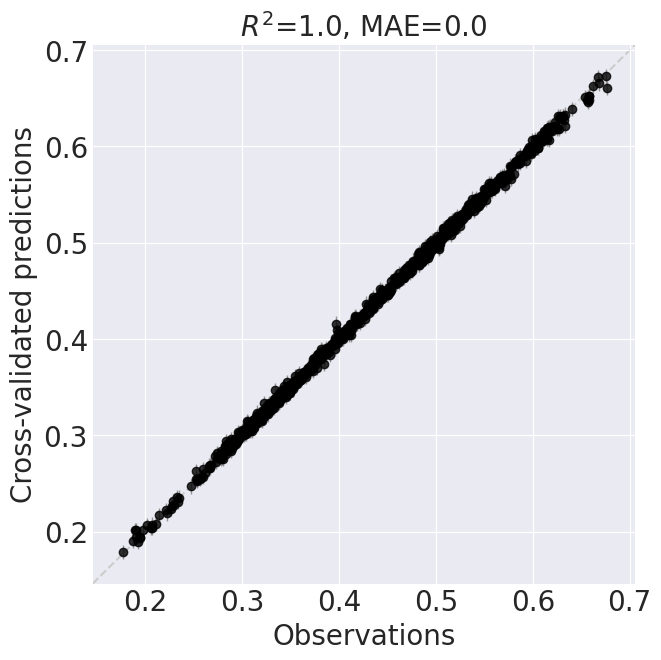

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(MaxAbsScaler(input_matrix), learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7500000000000001, verbosity=0)
Done fitting L0 models in 110.32 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 176 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 178.00 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.579436e-02,2.135796e+01,6.032575e-02,1.099987e-02,0.035849
Random Forest Regressor,2.918372e-03,6.925936e-01,2.797434e-03,1.634253e-05,0.998568
Support Vector Regressor,5.429719e-02,1.331431e+01,2.548375e-02,3.597606e-03,0.684666
Kernel Ridge Regressor,1.323622e-02,2.936132e+00,1.129011e-02,3.026642e-04,0.973471
K-NN Regressor,2.865414e-02,7.306084e+00,2.480104e-02,1.436151e-03,0.874120
Gaussian Process Regressor,9.833490e-10,2.301810e-07,1.153509e-09,2.297558e-18,1.000000
Gradient Boosting Regressor,5.671612e-03,1.362263e+00,5.292449e-03,6.017720e-05,0.994725
TPOT Regressor,1.618796e-03,3.840654e-01,1.412566e-03,4.615842e-06,0.999595
Ensemble Model,4.425069e-04,1.042717e-01,3.952472e-04,3.520328e-07,0.999969


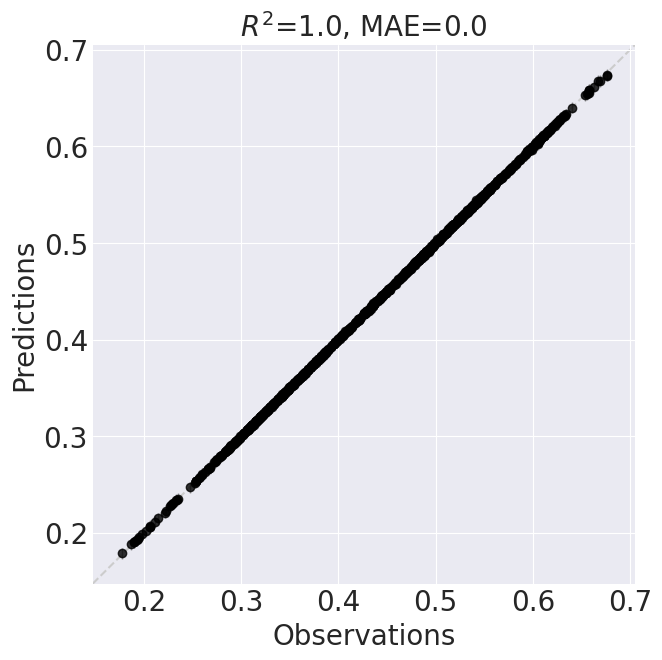

Done building models in 365.48 s
Finding all possible categorical designs…
Done finding categorical designs in 84.89 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.17 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,0.692453
1,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,0.689893
2,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.688301
3,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.688283
4,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,0.688016
5,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,0.687232


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 3.15 s


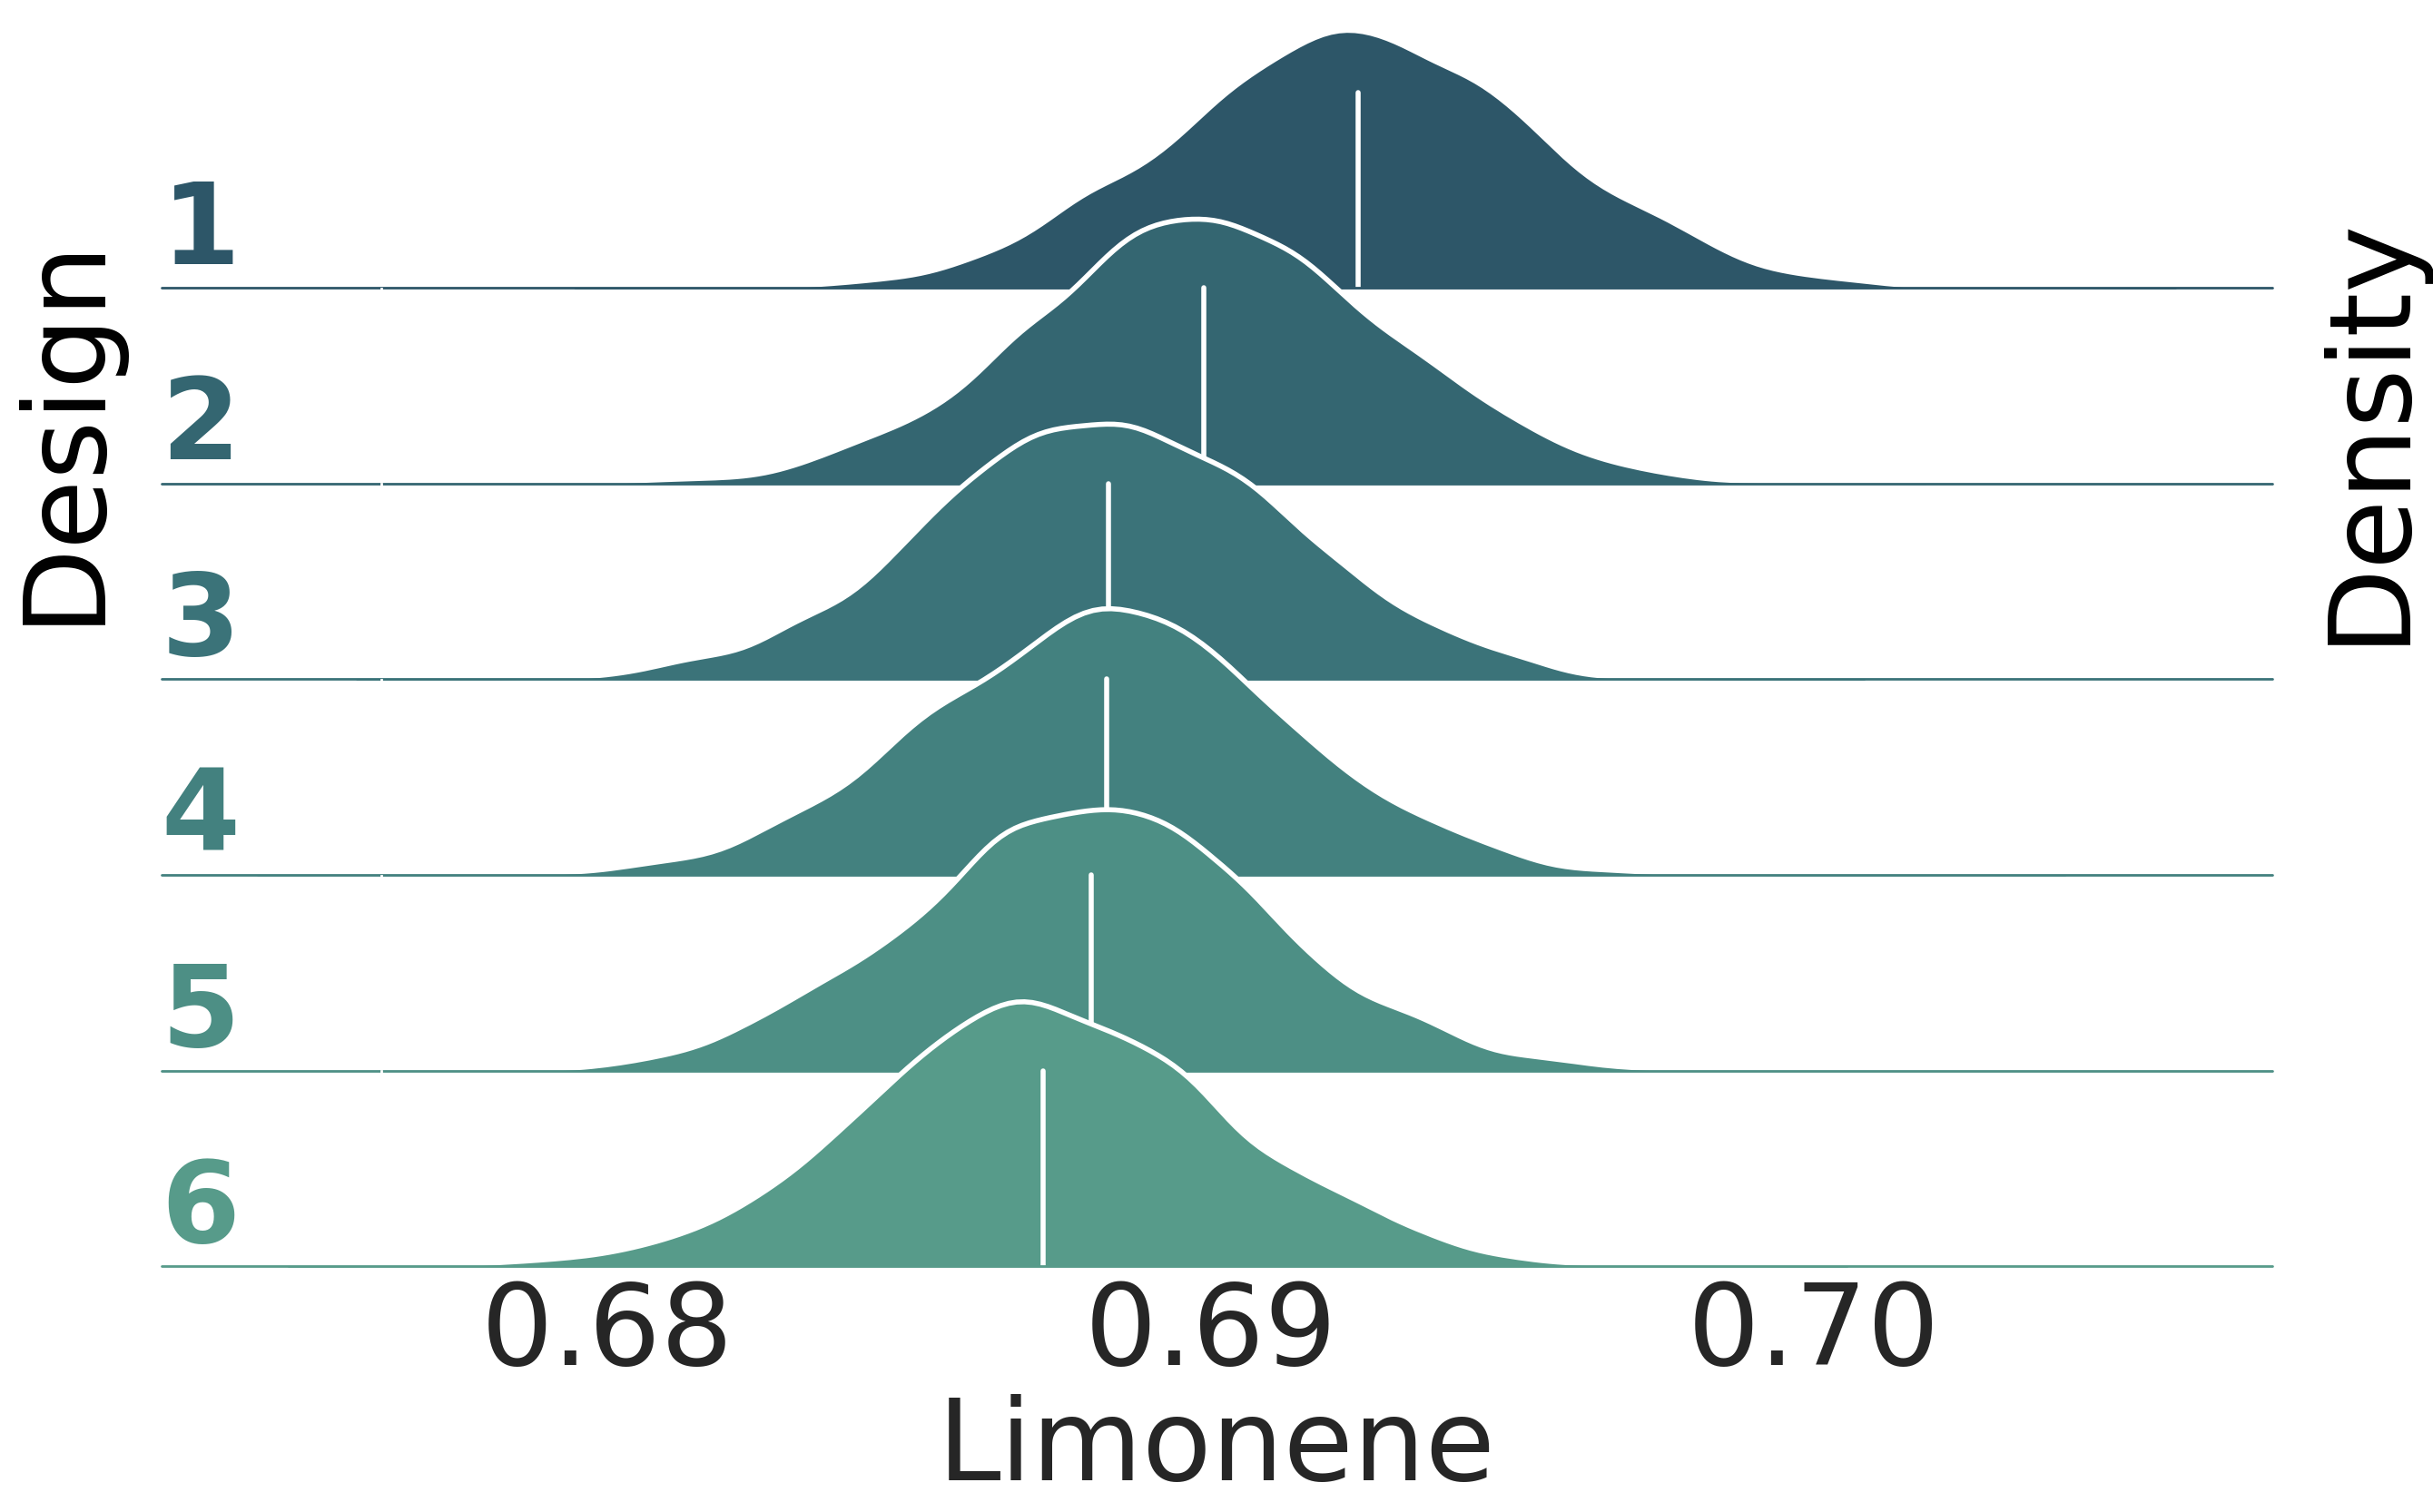

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.97 s
Done computing success probabilities in 0.98 s


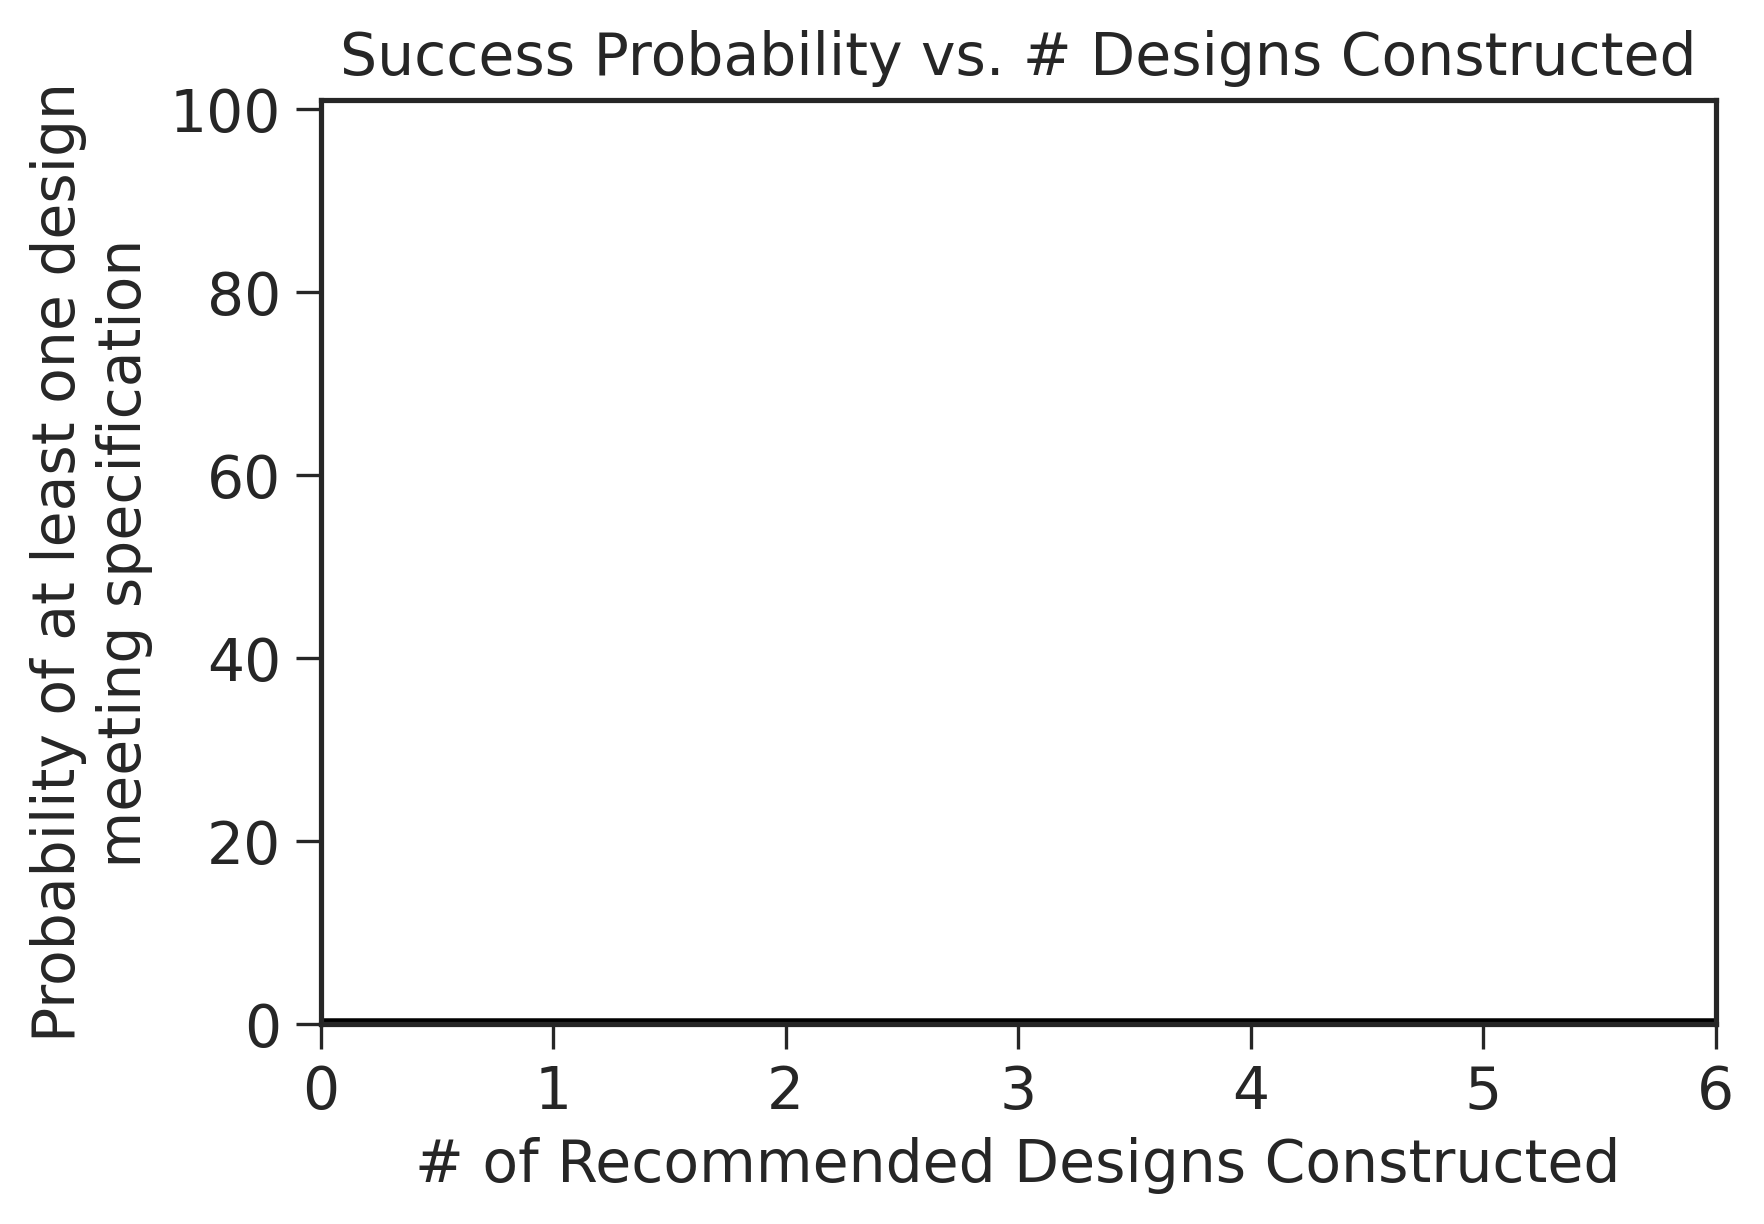

CPU times: user 17min 23s, sys: 1min 13s, total: 18min 37s
Wall time: 34min 14s


In [10]:
%%time
art = RecommendationEngine(df=df, alpha = 0, **art_params)

## alpha = 1

In [27]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': user_params['cross_val'],
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'] + "_alpha = 1",
    'last_dashes_denote_replicates': False,
    'cross_val_partitions': 5,
    'input_var_type': 'categorical',
}

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 1000 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 97.26 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 166 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 167.59 s
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 90.83 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 160 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 162.32 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0)
Done fitting L0 models in 96.35 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 169 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 170.58 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=10, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Done fitting L0 models in 95.41 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 146 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 147.98 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(StandardScaler(input_matrix), learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.4, verbosity=0)
Done fitting L0 models in 107.77 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 151 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 153.22 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.094939,23.599512,0.067285,0.013541,-0.186853
Random Forest Regressor,0.009147,2.191909,0.008584,0.000157,0.986208
Support Vector Regressor,0.055903,13.795103,0.027295,0.003870,0.660777
Kernel Ridge Regressor,0.019481,4.325528,0.017517,0.000686,0.939838
K-NN Regressor,0.035275,9.154567,0.029762,0.002130,0.813293
Gaussian Process Regressor,0.002955,0.725112,0.002747,0.000016,0.998573
Gradient Boosting Regressor,0.007225,1.747865,0.006488,0.000094,0.991734
TPOT Regressor,0.004829,1.180906,0.004549,0.000044,0.996142
Ensemble Model,0.002586,0.630056,0.002320,0.000012,0.998942


Done with 5-fold cross-validation in 1542.83 s


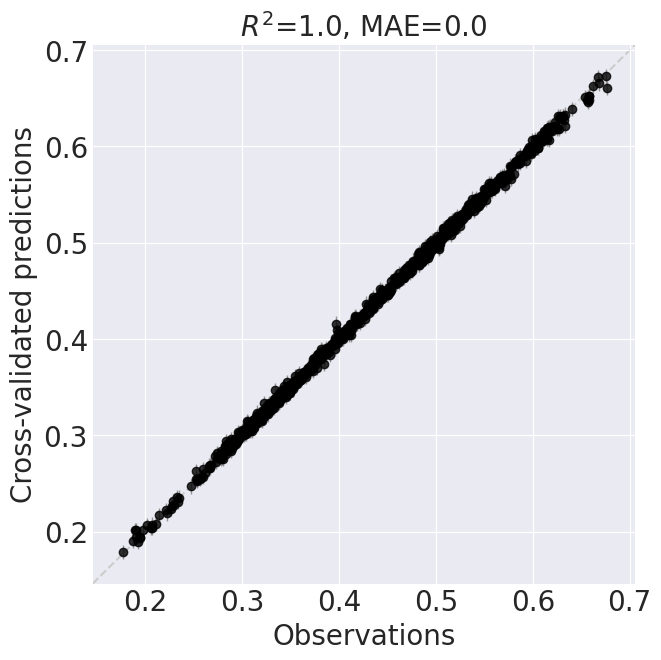

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(MaxAbsScaler(input_matrix), learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7500000000000001, verbosity=0)
Done fitting L0 models in 108.09 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 180 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 182.06 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,8.579436e-02,2.135796e+01,6.032575e-02,1.099987e-02,0.035849
Random Forest Regressor,2.918372e-03,6.925936e-01,2.797434e-03,1.634253e-05,0.998568
Support Vector Regressor,5.429719e-02,1.331431e+01,2.548375e-02,3.597606e-03,0.684666
Kernel Ridge Regressor,1.323622e-02,2.936132e+00,1.129011e-02,3.026642e-04,0.973471
K-NN Regressor,2.865414e-02,7.306084e+00,2.480104e-02,1.436151e-03,0.874120
Gaussian Process Regressor,9.833490e-10,2.301810e-07,1.153509e-09,2.297558e-18,1.000000
Gradient Boosting Regressor,5.671612e-03,1.362263e+00,5.292449e-03,6.017720e-05,0.994725
TPOT Regressor,1.618796e-03,3.840654e-01,1.412566e-03,4.615842e-06,0.999595
Ensemble Model,4.425069e-04,1.042717e-01,3.952472e-04,3.520328e-07,0.999969


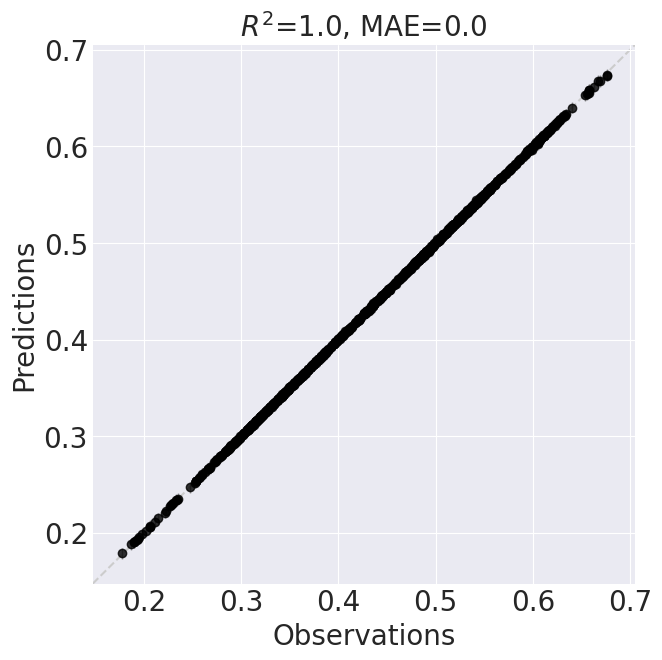

Done building models in 369.00 s
Finding all possible categorical designs…
Done finding categorical designs in 87.33 s
Optimizing categorical designs…
Done with categorical optimization in 0.00 s
Choosing recommendations (19,683 candidates)…


Done choosing recommendations in 0.15 s


,AtoB,HMGS,HMGR,MK,PMK,PMD,GPPS,Idi,Limonene Synthase,Limonene
0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,0.648478
1,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,0.677110
2,2.0,2.0,2.0,1.0,2.0,0.0,2.0,2.0,2.0,0.673213
3,2.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.662570
4,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.623255
5,2.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,2.0,0.640170


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 0.93 s


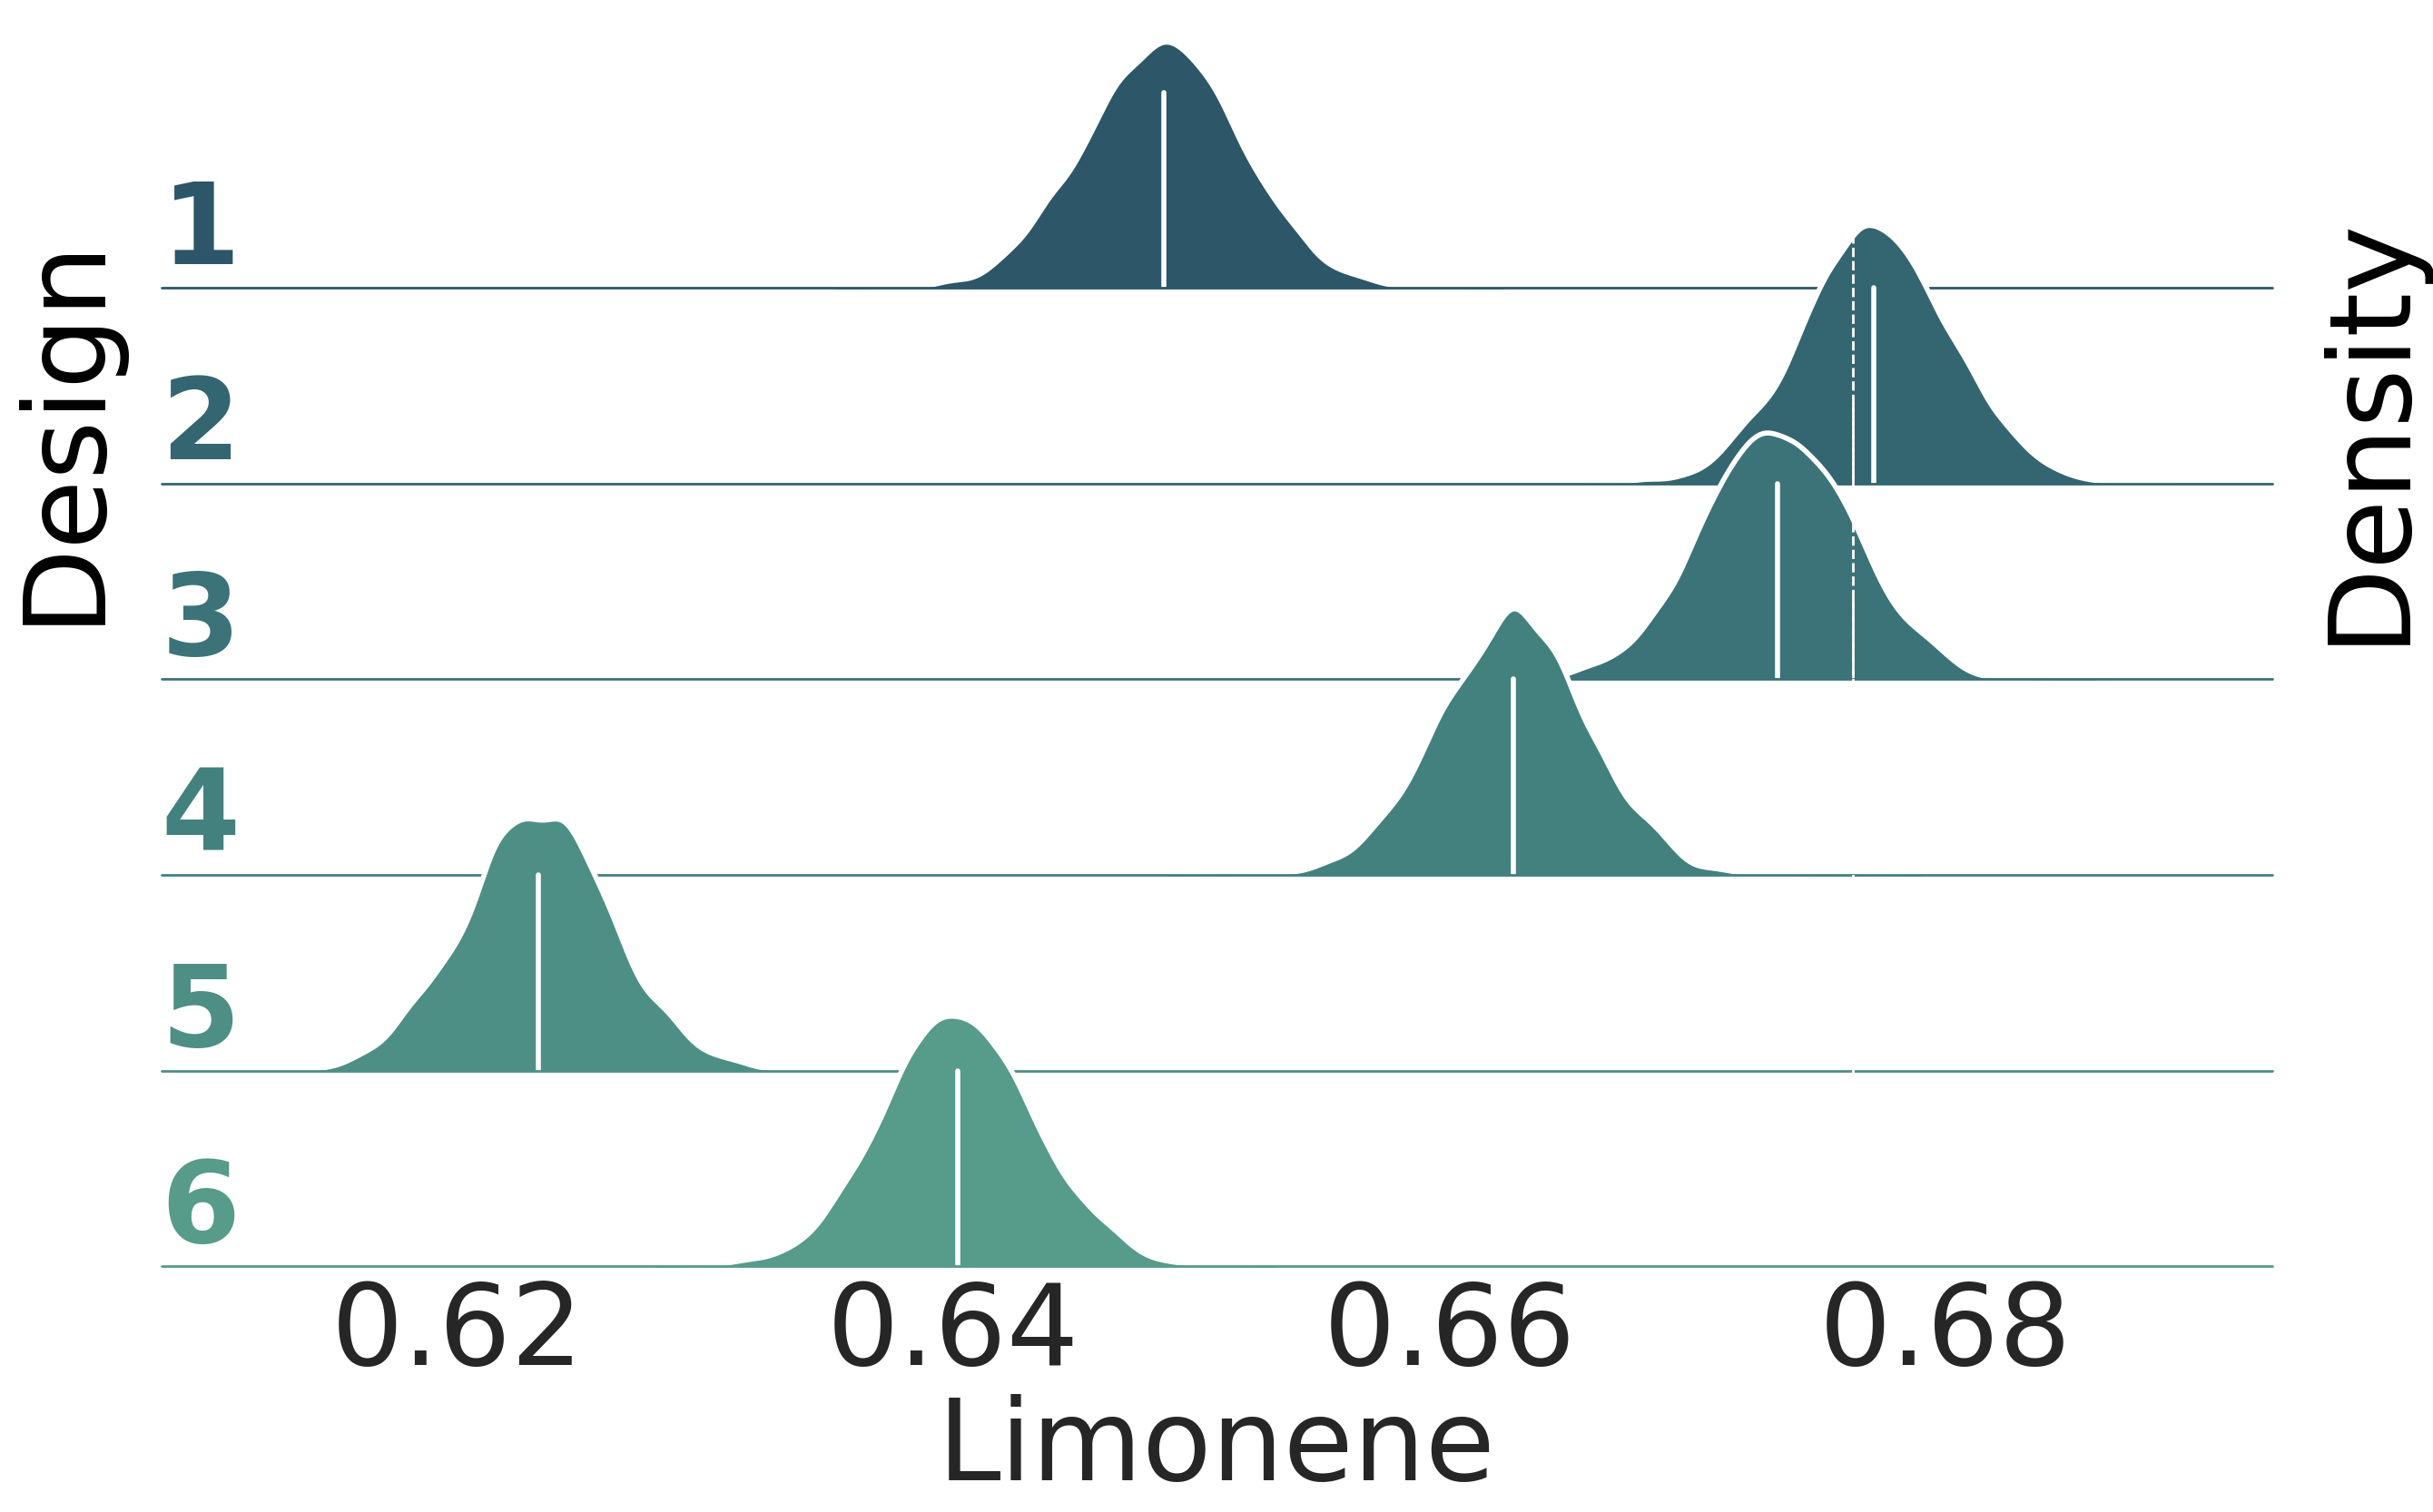

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.84 s
Done computing success probabilities in 0.84 s


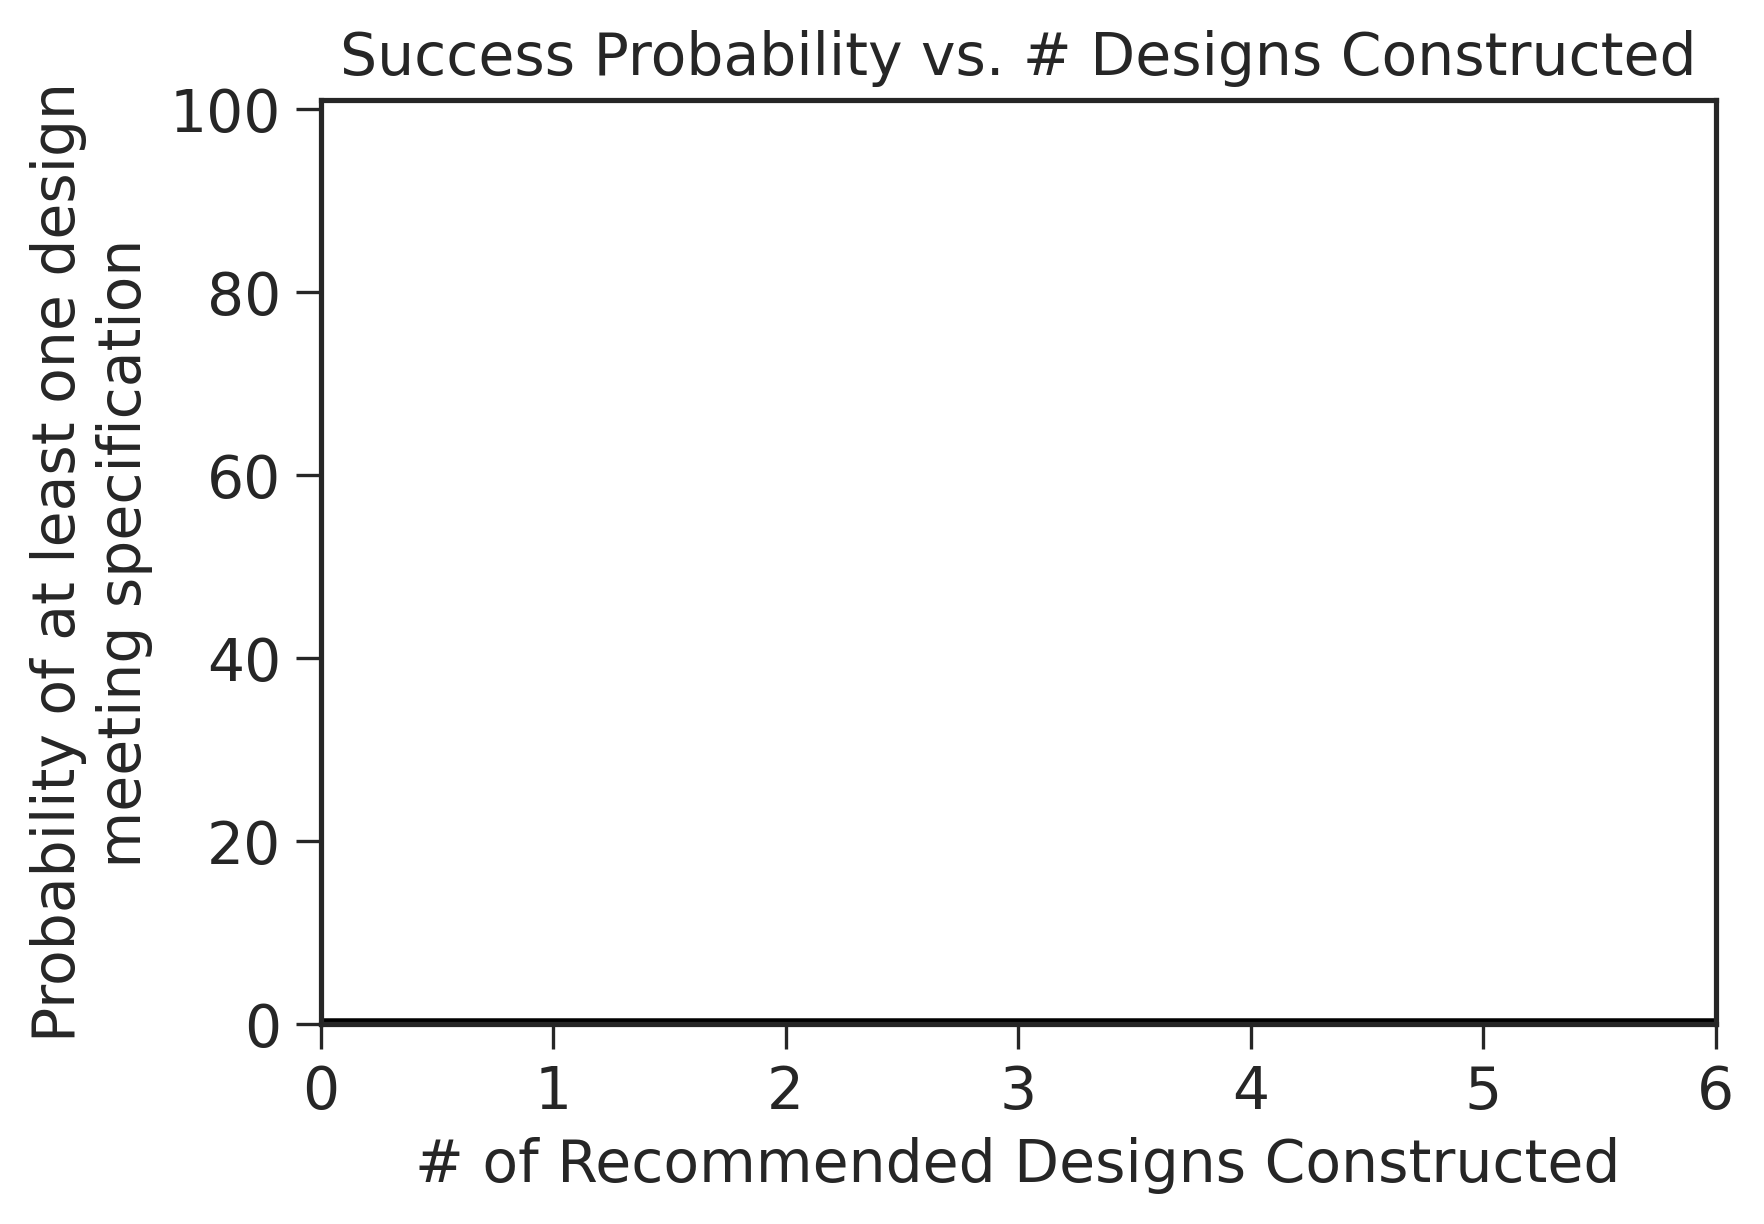

CPU times: user 17min 16s, sys: 19.9 s, total: 17min 36s
Wall time: 33min 28s


In [28]:
%%time
art = RecommendationEngine(df=df, alpha = 1, **art_params)